# Predição de Diabetes | Classificação com Multiplos Modelos



In [ ]:
# !pip uninstall scikit-learn --yes
# !pip uninstall imbalanced-learn --yes
# !pip install scikit-learn==1.2.2
# !pip install imbalanced-learn

## Importanto as bibliotécas

In [ ]:
# Importando as bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay, roc_curve, roc_auc_score, accuracy_score,
    f1_score, precision_score, recall_score
    )

## Importando Dados

In [ ]:
# Carregando o arquivo com os dados
# https://www.kaggle.com/datasets/prosperchuks/health-dataset

df = pd.read_csv('diabetes_data.csv')
pd.set_option('display.max_columns',30)

# Imprimindo um resumo dos dados
df.head()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Imprimindo informações básicas do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   70692 non-null  float64
 1   Sex                   70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   HeartDiseaseorAttack  70692 non-null  float64
 7   PhysActivity          70692 non-null  float64
 8   Fruits                70692 non-null  float64
 9   Veggies               70692 non-null  float64
 10  HvyAlcoholConsump     70692 non-null  float64
 11  GenHlth               70692 non-null  float64
 12  MentHlth              70692 non-null  float64
 13  PhysHlth              70692 non-null  float64
 14  DiffWalk              70692 non-null  float64
 15  Stroke             

## Analise do DataSet

### Verificando valores nulos

In [ ]:
# Imprimindo valores nulos no dataframe
df.isnull().sum()

,0
Age,0
Sex,0
HighChol,0
CholCheck,0
BMI,0
Smoker,0
HeartDiseaseorAttack,0
PhysActivity,0
Fruits,0
Veggies,0


### Verificando valores únicos das variáveis

In [ ]:
# Crio uma lista para armazenar a quantidade de valores únicos de cada coluna
unique_vals = []

# Para cada coluna do dataframe (cada variável)
for col in df.columns:
    # Salvo o valor único na lista
    unival = df[col].nunique()
    unique_vals.append(unival)

# Imprimo um dataframe simples com os valores únicos de cada variável
pd.DataFrame(unique_vals, columns = ['Unique_Values'], index=df.columns)

,Unique_Values
Age,13
Sex,2
HighChol,2
CholCheck,2
BMI,80
Smoker,2
HeartDiseaseorAttack,2
PhysActivity,2
Fruits,2
Veggies,2


É evidente dos dados acima que a maioria dos atributos são de natureza categórica, na sua maioria binária e apenas alguns deles possuem valores ordinais.

### Separando as colunas numéricas das categóricas

In [ ]:
# Imprimindo as colunas do dataframe
df.columns

Index(['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk',
       'Stroke', 'HighBP', 'Diabetes'],
      dtype='object')

In [ ]:
# Identificando variáveis categóricas e numéricas com base nos valores únicos
categorical_cols = ['Sex', 'HighChol', 'CholCheck', 'Smoker', 'HeartDiseaseorAttack',
                   'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
                   'GenHlth', 'DiffWalk', 'Stroke', 'HighBP', 'Diabetes']

numerical_cols = ['Age', 'BMI', 'MentHlth', 'PhysHlth']

### Análise do desbalanceamento da variável alvo (Diabetes)

Contagem da variável alvo (Diabetes):
Diabetes
0.0    35346
1.0    35346
Name: count, dtype: int64

Proporção de cada classe (%):
Diabetes
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64

Razão de desbalanceamento: 1.00


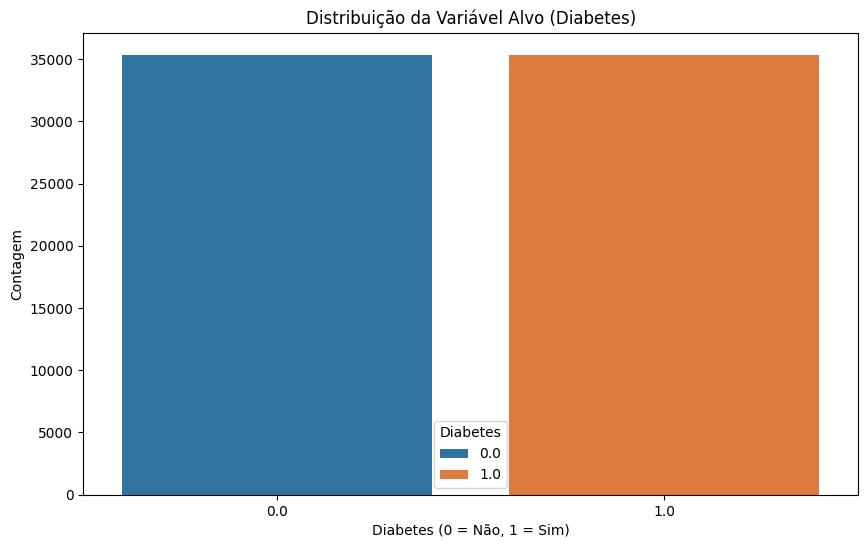

In [ ]:
# Contagem de valores da variável alvo
target_counts = df['Diabetes'].value_counts()
print("Contagem da variável alvo (Diabetes):")
print(target_counts)

# Proporção de cada classe
target_props = df['Diabetes'].value_counts(normalize=True) * 100
print("\nProporção de cada classe (%):")
print(target_props)

# Razão de desbalanceamento
imbalance_ratio = target_counts.max() / target_counts.min()
print(f"\nRazão de desbalanceamento: {imbalance_ratio:.2f}")

# Visualização do desbalanceamento
plt.figure(figsize=(10, 6))
sns.countplot(x='Diabetes', data=df, hue='Diabetes', palette=['#1f77b4','#f77423'])
plt.title('Distribuição da Variável Alvo (Diabetes)')
plt.xlabel('Diabetes (0 = Não, 1 = Sim)')
plt.ylabel('Contagem')
# plt.savefig('stroke_distribution.png')
# print("Gráfico da distribuição salvo como 'stroke_distribution.png'")
plt.show()
plt.close()



### Análise Estatística das variáveis numéricas

In [ ]:
# Estatísticas descritivas para variáveis numéricas
numeric_stats = df[numerical_cols].describe().T

# Adicionando mais métricas estatísticas
numeric_stats['mode'] = df[numerical_cols].mode().iloc[0]
numeric_stats['skewness'] = df[numerical_cols].skew()
numeric_stats['kurtosis'] = df[numerical_cols].kurtosis()
numeric_stats['iqr'] = numeric_stats['75%'] - numeric_stats['25%']
numeric_stats['cv'] = numeric_stats['std'] / numeric_stats['mean'] * 100

# Imprimindo as estatísticas
print(numeric_stats)

            count       mean        std   min   25%   50%   75%   max  mode  \
Age       70692.0   8.584055   2.852153   1.0   7.0   9.0  11.0  13.0  10.0   
BMI       70692.0  29.856985   7.113954  12.0  25.0  29.0  33.0  98.0  27.0   
MentHlth  70692.0   3.752037   8.155627   0.0   0.0   0.0   2.0  30.0   0.0   
PhysHlth  70692.0   5.810417  10.062261   0.0   0.0   0.0   6.0  30.0   0.0   

          skewness  kurtosis  iqr          cv  
Age      -0.545923 -0.213232  4.0   33.226176  
BMI       1.719180  7.164081  8.0   23.826765  
MentHlth  2.388110  4.491547  2.0  217.365302  
PhysHlth  1.657304  1.179731  6.0  173.176219  


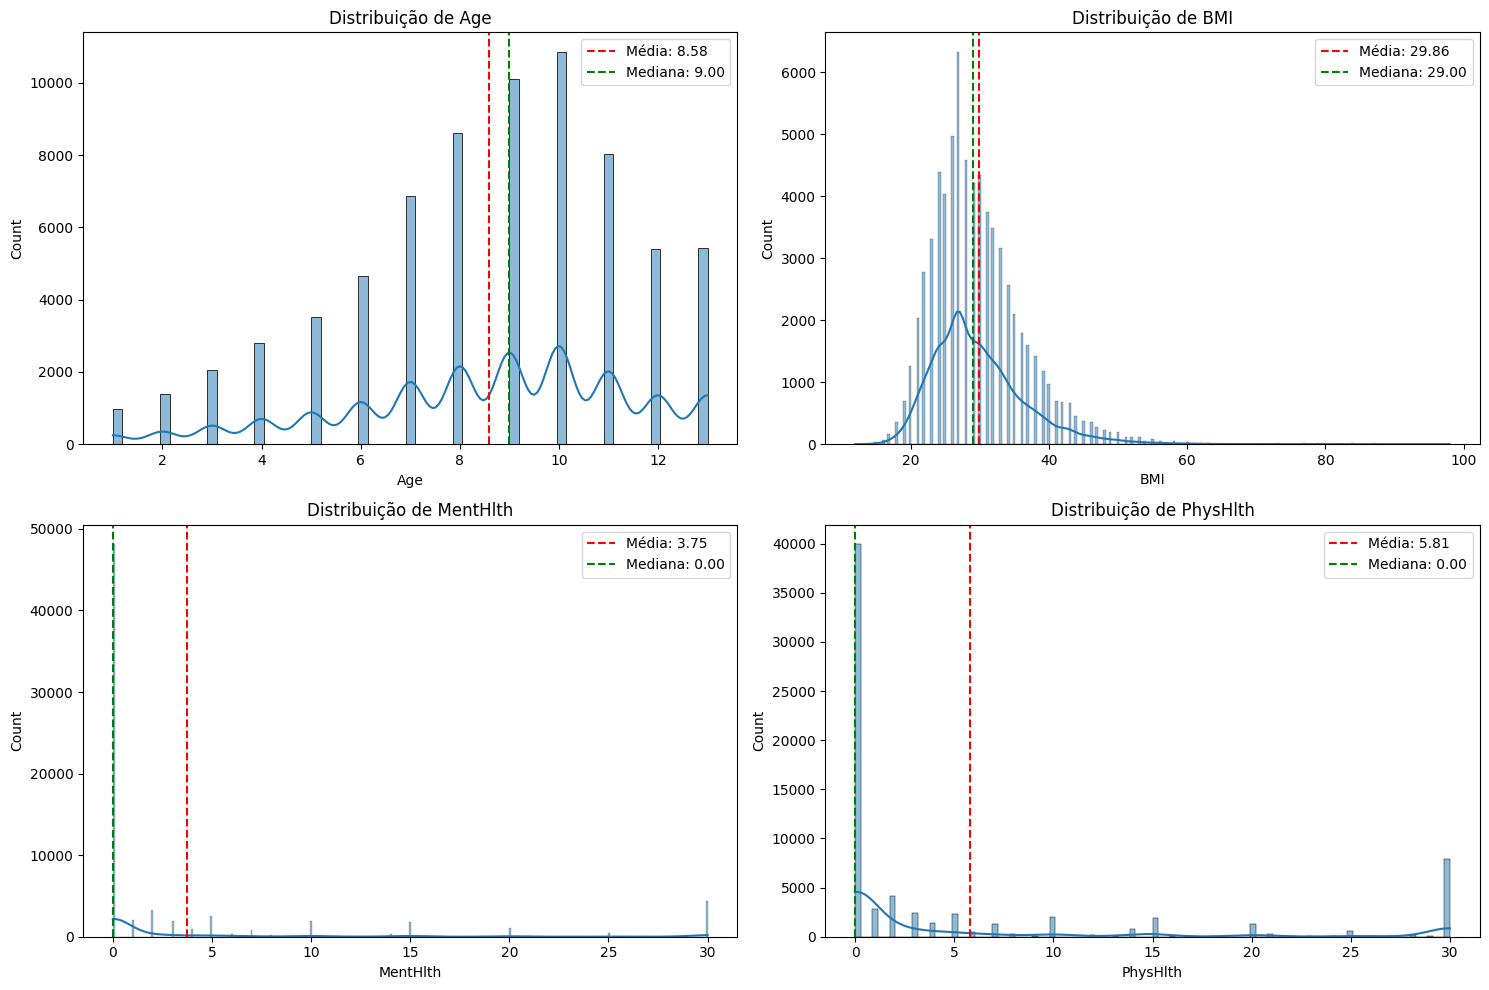

In [ ]:
# Visualizando a distribuição das variáveis ordianais
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribuição de {col}')
    plt.axvline(df[col].mean(), color='red', linestyle='--', label=f'Média: {df[col].mean():.2f}')
    plt.axvline(df[col].median(), color='green', linestyle='--', label=f'Mediana: {df[col].median():.2f}')
    plt.legend()
plt.tight_layout()
# plt.savefig('numeric_distributions.png')
# print("Gráficos das distribuições numéricas salvos como 'numeric_distributions.png'")
plt.show()
plt.close()



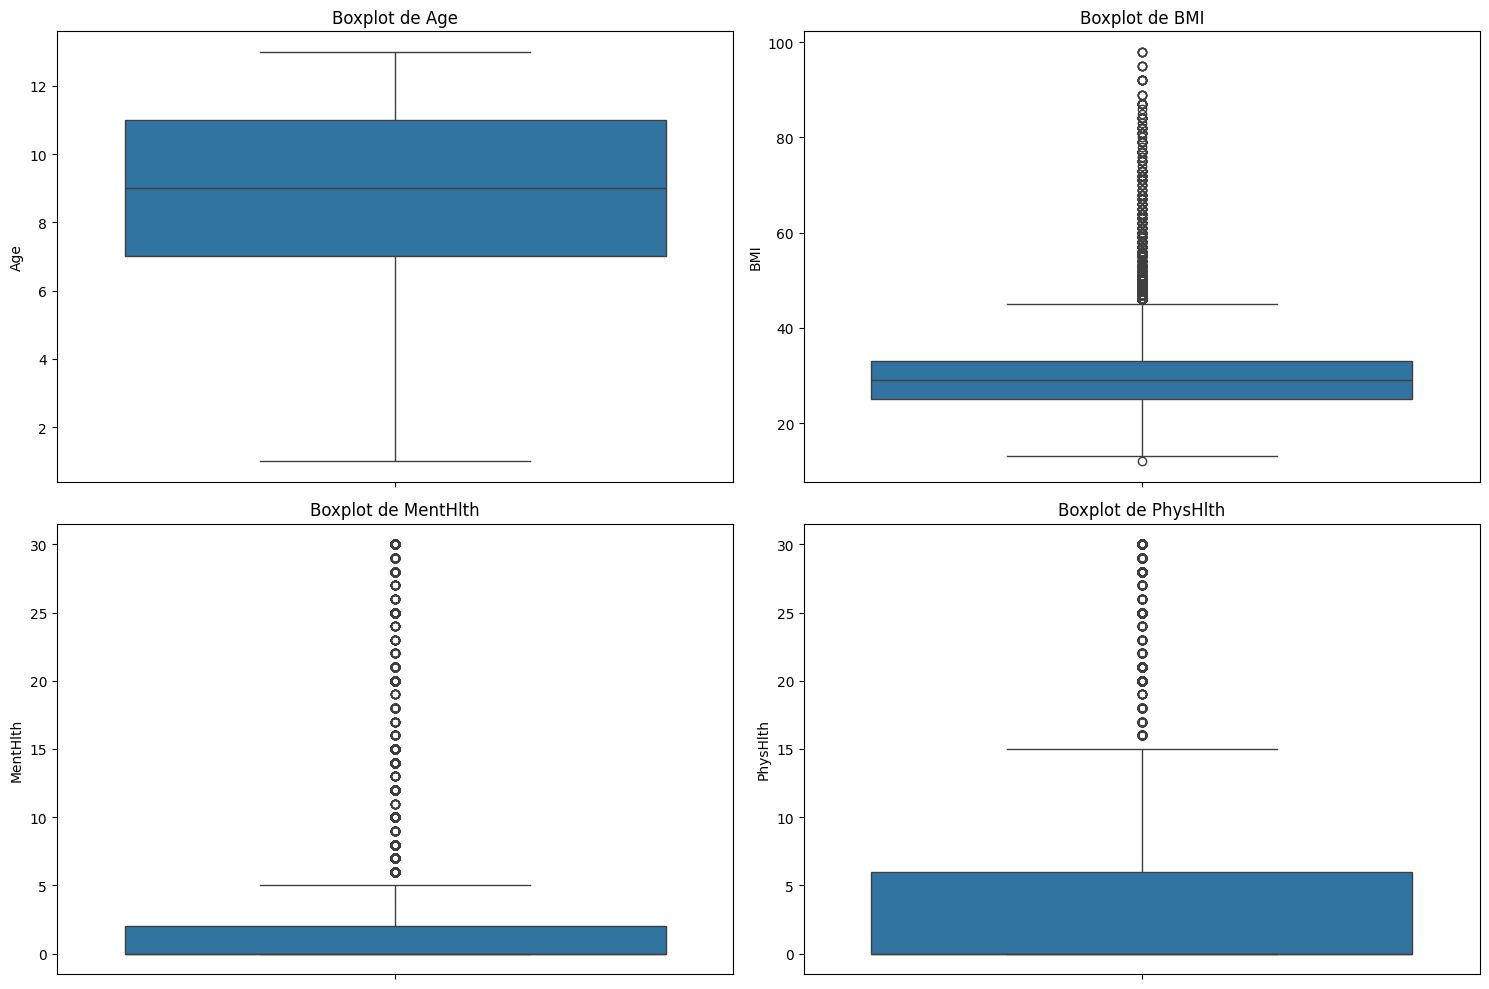

In [ ]:
# Boxplots para identificar outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
# plt.savefig('numeric_boxplots.png')
# print("Boxplots das variáveis numéricas salvos como 'numeric_boxplots.png'")
plt.show()
plt.close()



### Análise Estatística das variáveis categóricas


Análise da variável: Sex
----------------------------------------
Valores únicos: 2
Moda (valor mais frequente): 0.0

Contagem de cada categoria:
Sex
0.0    38386
1.0    32306
Name: count, dtype: int64

Proporção de cada categoria (%):
Sex
0.0    54.300345
1.0    45.699655
Name: proportion, dtype: float64

Razão de desbalanceamento: 1.19


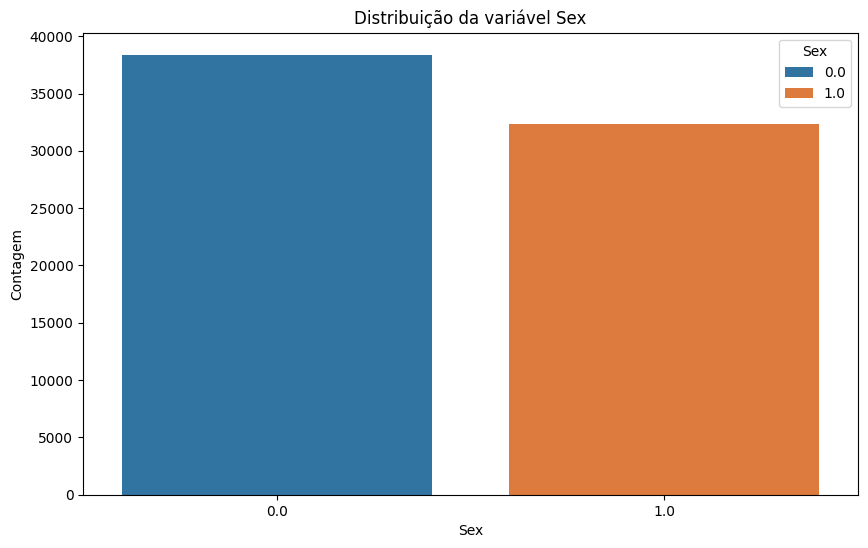


Análise da variável: HighChol
----------------------------------------
Valores únicos: 2
Moda (valor mais frequente): 1.0

Contagem de cada categoria:
HighChol
0.0    33529
1.0    37163
Name: count, dtype: int64

Proporção de cada categoria (%):
HighChol
0.0    47.429695
1.0    52.570305
Name: proportion, dtype: float64

Razão de desbalanceamento: 1.11


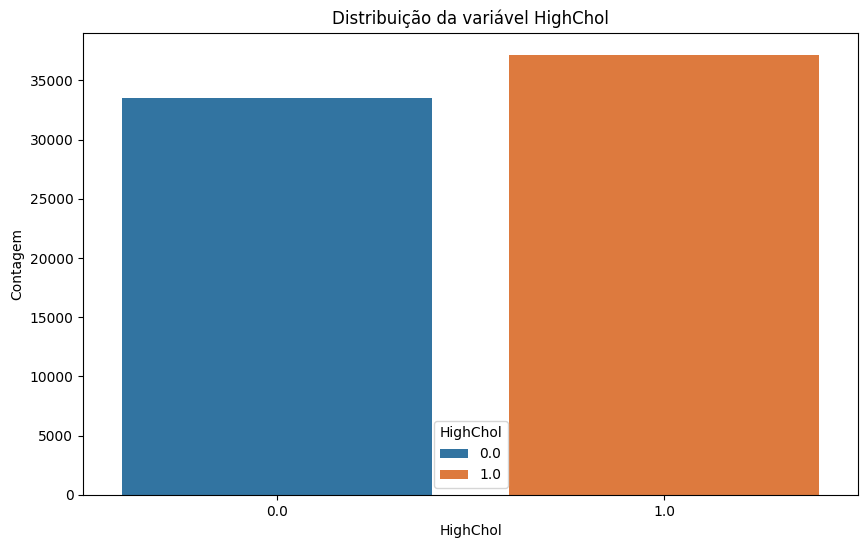


Análise da variável: CholCheck
----------------------------------------
Valores únicos: 2
Moda (valor mais frequente): 1.0

Contagem de cada categoria:
CholCheck
0.0     1749
1.0    68943
Name: count, dtype: int64

Proporção de cada categoria (%):
CholCheck
0.0     2.474113
1.0    97.525887
Name: proportion, dtype: float64

Razão de desbalanceamento: 39.42


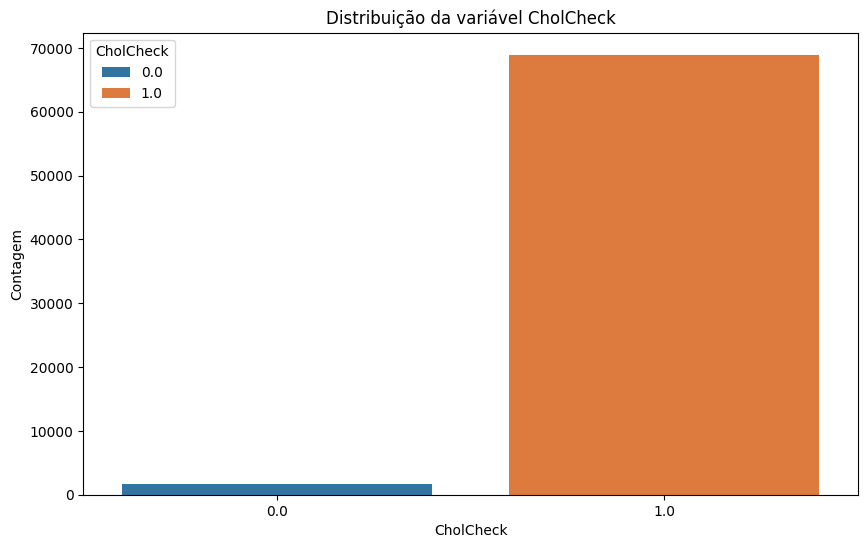


Análise da variável: Smoker
----------------------------------------
Valores únicos: 2
Moda (valor mais frequente): 0.0

Contagem de cada categoria:
Smoker
0.0    37094
1.0    33598
Name: count, dtype: int64

Proporção de cada categoria (%):
Smoker
0.0    52.472698
1.0    47.527302
Name: proportion, dtype: float64

Razão de desbalanceamento: 1.10


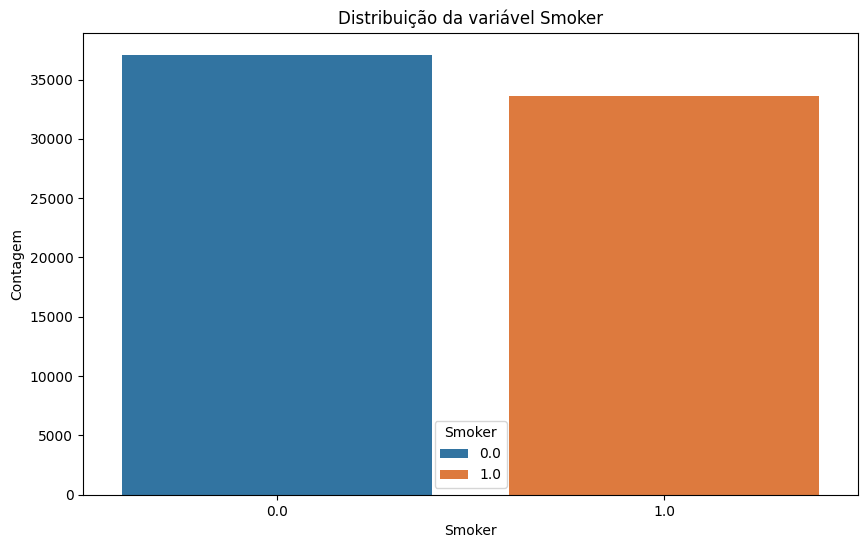


Análise da variável: HeartDiseaseorAttack
----------------------------------------
Valores únicos: 2
Moda (valor mais frequente): 0.0

Contagem de cada categoria:
HeartDiseaseorAttack
0.0    60243
1.0    10449
Name: count, dtype: int64

Proporção de cada categoria (%):
HeartDiseaseorAttack
0.0    85.218978
1.0    14.781022
Name: proportion, dtype: float64

Razão de desbalanceamento: 5.77


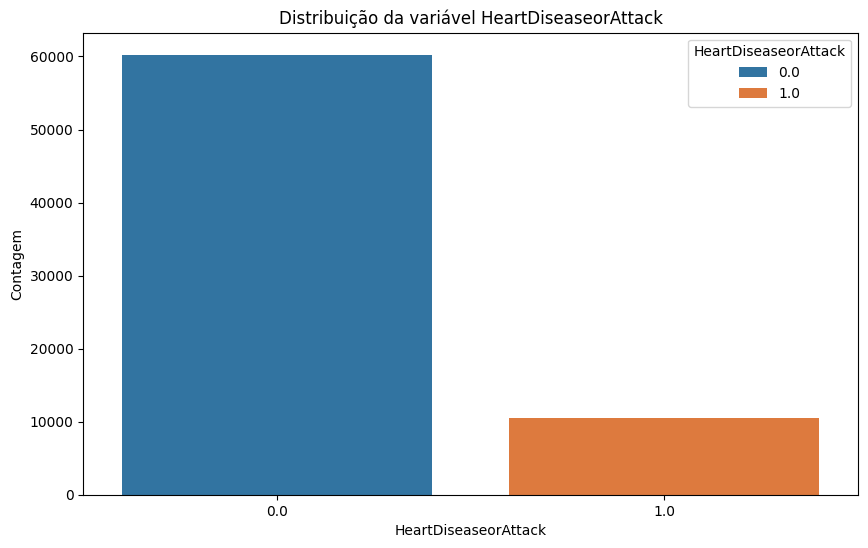


Análise da variável: PhysActivity
----------------------------------------
Valores únicos: 2
Moda (valor mais frequente): 1.0

Contagem de cada categoria:
PhysActivity
0.0    20993
1.0    49699
Name: count, dtype: int64

Proporção de cada categoria (%):
PhysActivity
0.0    29.69643
1.0    70.30357
Name: proportion, dtype: float64

Razão de desbalanceamento: 2.37


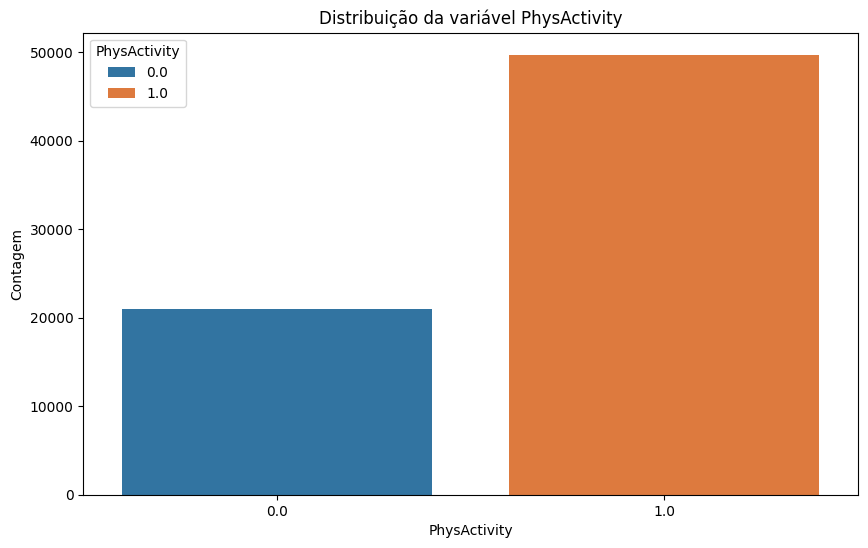


Análise da variável: Fruits
----------------------------------------
Valores únicos: 2
Moda (valor mais frequente): 1.0

Contagem de cada categoria:
Fruits
0.0    27443
1.0    43249
Name: count, dtype: int64

Proporção de cada categoria (%):
Fruits
0.0    38.820517
1.0    61.179483
Name: proportion, dtype: float64

Razão de desbalanceamento: 1.58


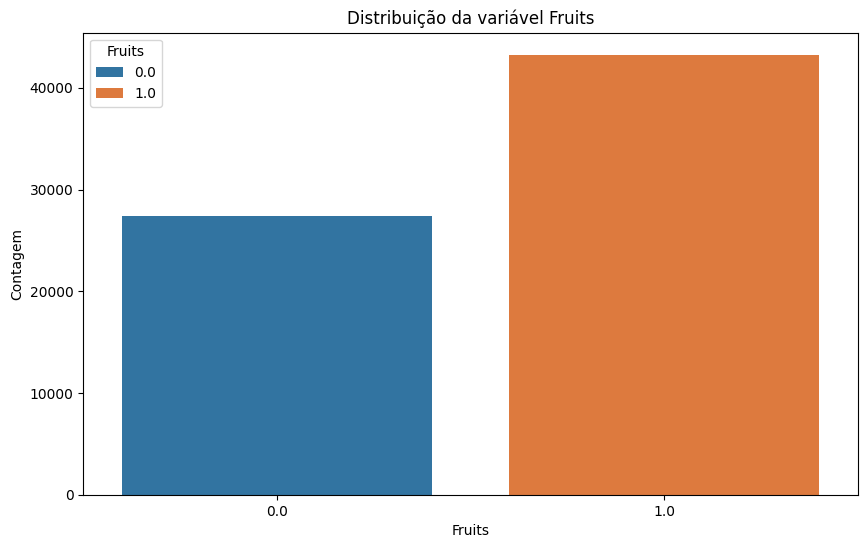


Análise da variável: Veggies
----------------------------------------
Valores únicos: 2
Moda (valor mais frequente): 1.0

Contagem de cada categoria:
Veggies
0.0    14932
1.0    55760
Name: count, dtype: int64

Proporção de cada categoria (%):
Veggies
0.0    21.122616
1.0    78.877384
Name: proportion, dtype: float64

Razão de desbalanceamento: 3.73


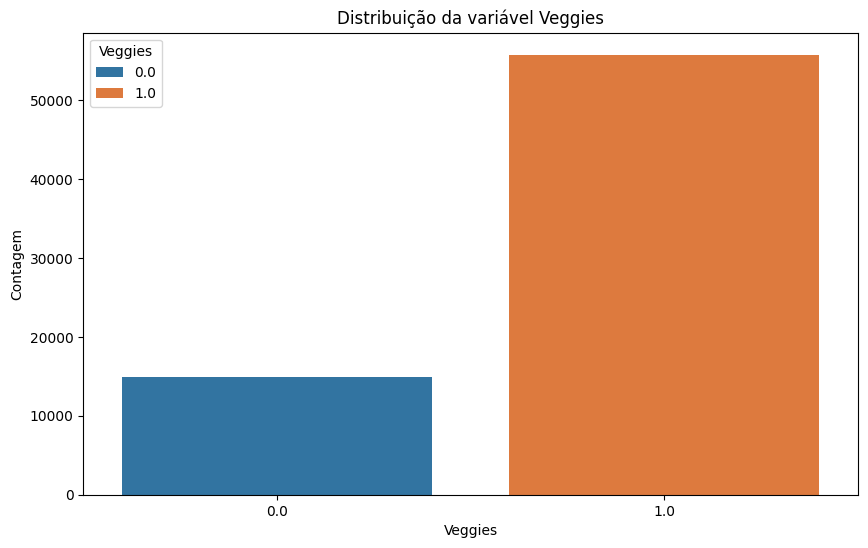


Análise da variável: HvyAlcoholConsump
----------------------------------------
Valores únicos: 2
Moda (valor mais frequente): 0.0

Contagem de cada categoria:
HvyAlcoholConsump
0.0    67672
1.0     3020
Name: count, dtype: int64

Proporção de cada categoria (%):
HvyAlcoholConsump
0.0    95.727947
1.0     4.272053
Name: proportion, dtype: float64

Razão de desbalanceamento: 22.41


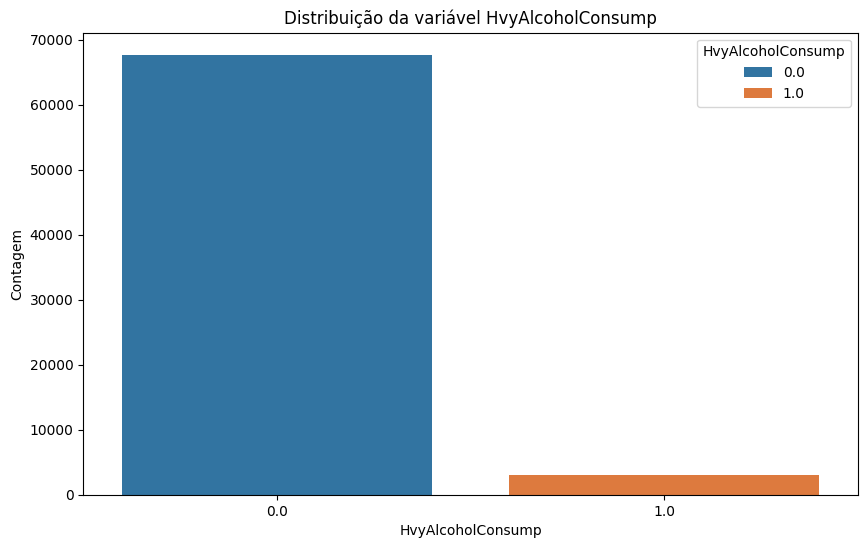


Análise da variável: GenHlth
----------------------------------------
Valores únicos: 5
Moda (valor mais frequente): 3.0

Contagem de cada categoria:
GenHlth
1.0     8282
2.0    19872
3.0    23427
4.0    13303
5.0     5808
Name: count, dtype: int64

Proporção de cada categoria (%):
GenHlth
1.0    11.715611
2.0    28.110677
3.0    33.139535
4.0    18.818254
5.0     8.215923
Name: proportion, dtype: float64

Razão de desbalanceamento: 4.03


<ipython-input-18-d2387d5f429e>:23: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=col_name, data=df, hue=col_name, palette=['#1f77b4','#f77423'])


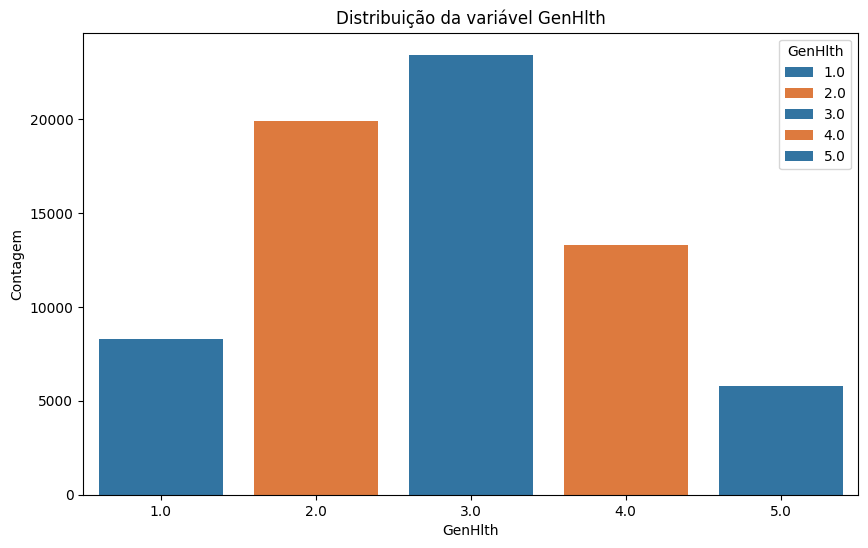


Análise da variável: DiffWalk
----------------------------------------
Valores únicos: 2
Moda (valor mais frequente): 0.0

Contagem de cada categoria:
DiffWalk
0.0    52826
1.0    17866
Name: count, dtype: int64

Proporção de cada categoria (%):
DiffWalk
0.0    74.726985
1.0    25.273015
Name: proportion, dtype: float64

Razão de desbalanceamento: 2.96


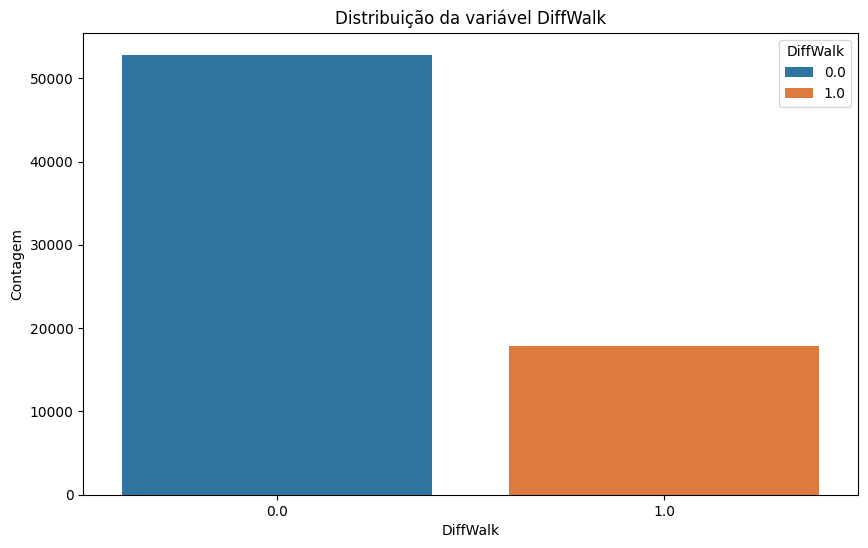


Análise da variável: Stroke
----------------------------------------
Valores únicos: 2
Moda (valor mais frequente): 0.0

Contagem de cada categoria:
Stroke
0.0    66297
1.0     4395
Name: count, dtype: int64

Proporção de cada categoria (%):
Stroke
0.0    93.782889
1.0     6.217111
Name: proportion, dtype: float64

Razão de desbalanceamento: 15.08


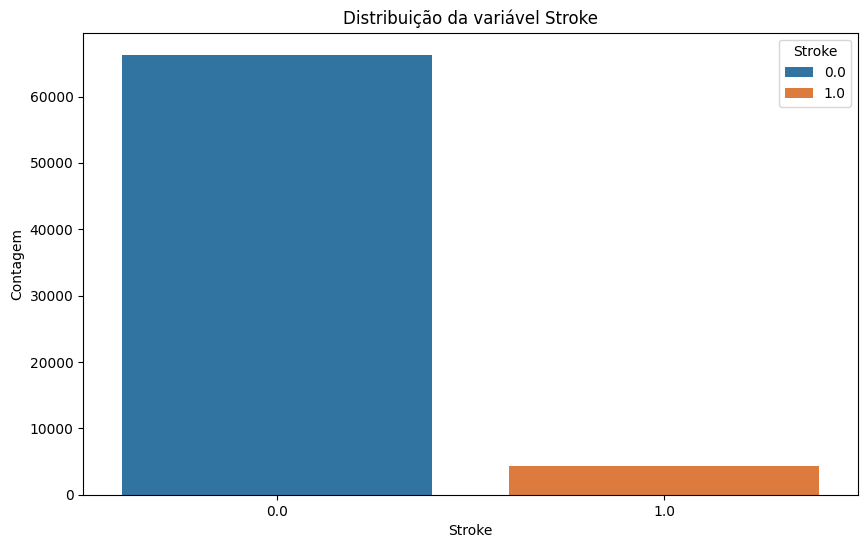


Análise da variável: HighBP
----------------------------------------
Valores únicos: 2
Moda (valor mais frequente): 1.0

Contagem de cada categoria:
HighBP
0.0    30860
1.0    39832
Name: count, dtype: int64

Proporção de cada categoria (%):
HighBP
0.0    43.654162
1.0    56.345838
Name: proportion, dtype: float64

Razão de desbalanceamento: 1.29


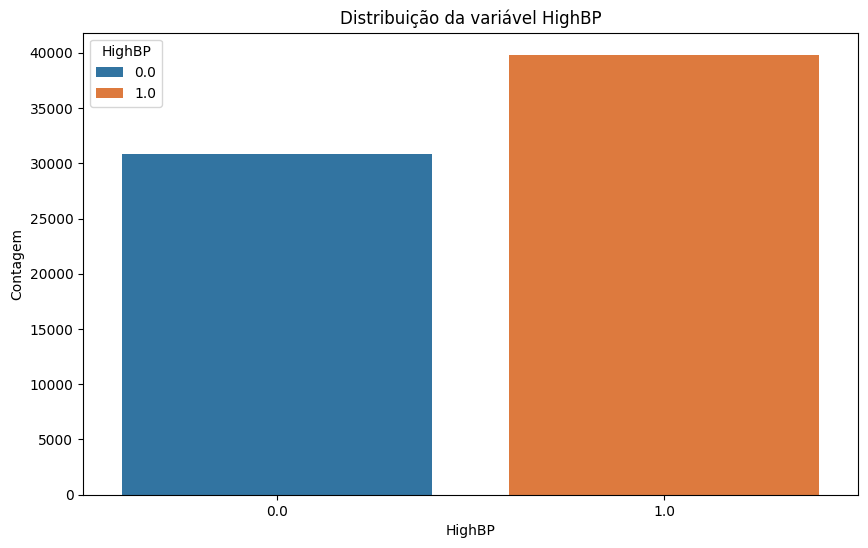


Análise da variável: Diabetes
----------------------------------------
Valores únicos: 2
Moda (valor mais frequente): 0.0

Contagem de cada categoria:
Diabetes
0.0    35346
1.0    35346
Name: count, dtype: int64

Proporção de cada categoria (%):
Diabetes
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64

Razão de desbalanceamento: 1.00


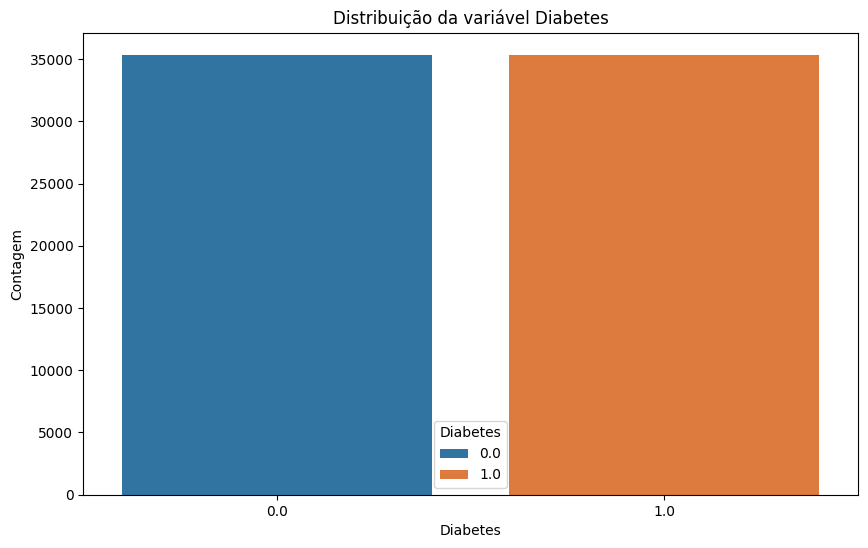

In [ ]:
# Função para analisar variáveis categóricas
def analyze_categorical(df, col_name):
    counts = df[col_name].value_counts().sort_index()
    proportions = df[col_name].value_counts(normalize=True).sort_index() * 100
    mode_value = df[col_name].mode()[0]

    print(f"\nAnálise da variável: {col_name}")
    print("-" * 40)
    print("Valores únicos:", df[col_name].nunique())
    print("Moda (valor mais frequente):", mode_value)
    print("\nContagem de cada categoria:")
    print(counts)
    print("\nProporção de cada categoria (%):")
    print(proportions)

    # Verificando desbalanceamento
    if len(counts) > 1:
        imbalance = counts.max() / counts.min()
        print(f"\nRazão de desbalanceamento: {imbalance:.2f}")

    # Visualização
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col_name, data=df, hue=col_name, palette=['#1f77b4','#f77423'])
    plt.title(f'Distribuição da variável {col_name}')
    plt.ylabel('Contagem')
    # plt.savefig(f'{col_name}_distribution.png')
    # print(f"Gráfico salvo como '{col_name}_distribution.png'")
    plt.show()
    plt.close()
    return counts, proportions

# Analisando cada variável categórica
for col in categorical_cols:
    analyze_categorical(df, col)

### Relação das Variáveis com a Variável Alvo (Diabetes)


Tabela de contingência entre Sex e Diabetes:
Diabetes    0.0    1.0
Sex                   
0.0       19975  18411
1.0       15371  16935
Chi-square: 139.26, p-value: 0.0000
A variável Sex tem relação estatisticamente significativa com Diabetes (p<0.05)


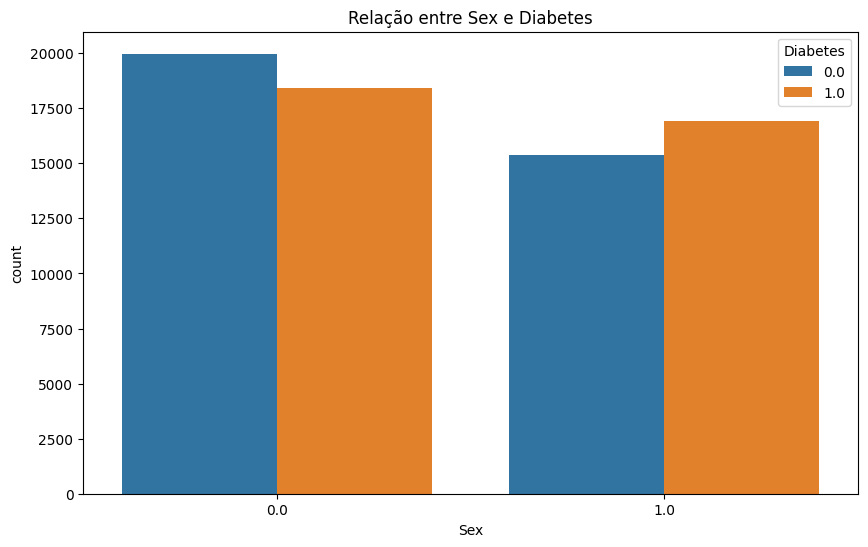


Tabela de contingência entre HighChol e Diabetes:
Diabetes    0.0    1.0
HighChol              
0.0       21869  11660
1.0       13477  23686
Chi-square: 5911.81, p-value: 0.0000
A variável HighChol tem relação estatisticamente significativa com Diabetes (p<0.05)


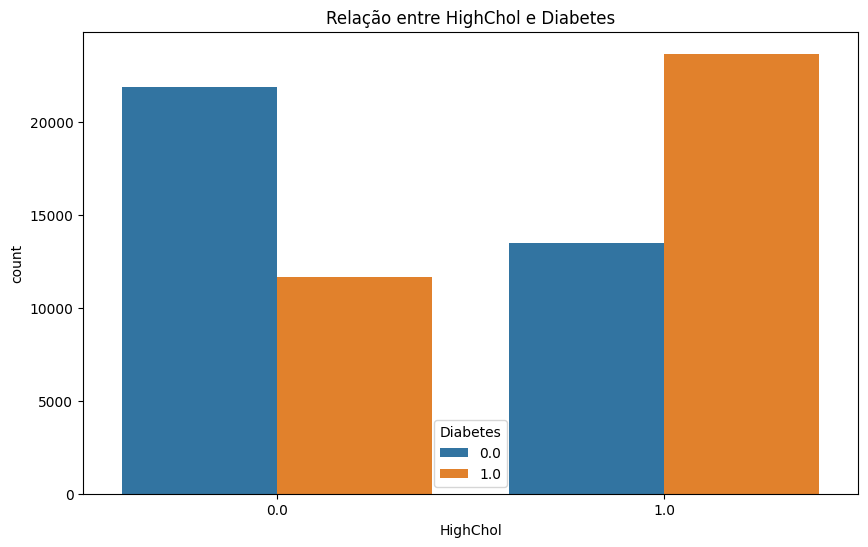


Tabela de contingência entre CholCheck e Diabetes:
Diabetes     0.0    1.0
CholCheck              
0.0         1508    241
1.0        33838  35105
Chi-square: 939.63, p-value: 0.0000
A variável CholCheck tem relação estatisticamente significativa com Diabetes (p<0.05)


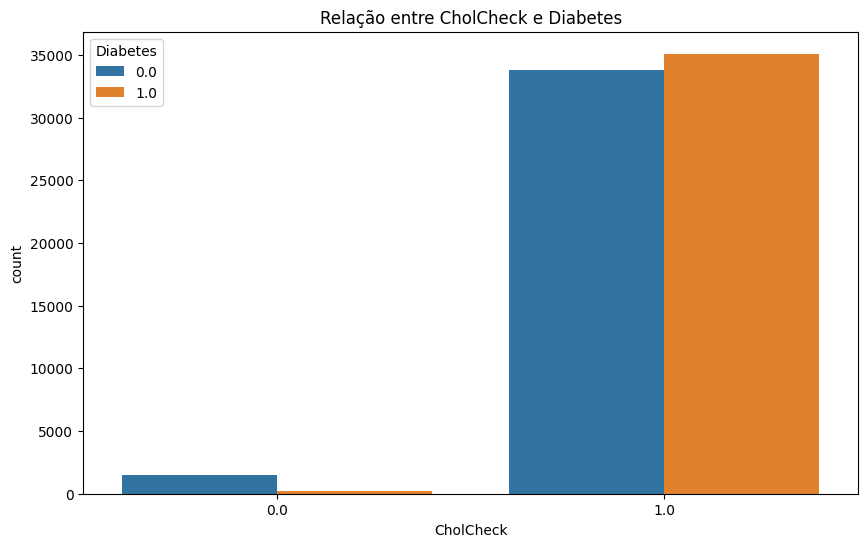


Tabela de contingência entre Smoker e Diabetes:
Diabetes    0.0    1.0
Smoker                
0.0       20065  17029
1.0       15281  18317
Chi-square: 522.48, p-value: 0.0000
A variável Smoker tem relação estatisticamente significativa com Diabetes (p<0.05)


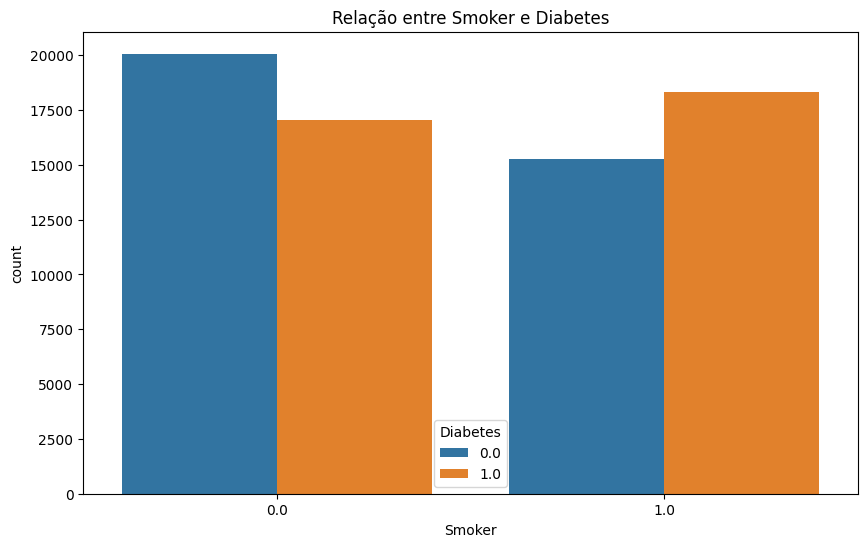


Tabela de contingência entre HeartDiseaseorAttack e Diabetes:
Diabetes                0.0    1.0
HeartDiseaseorAttack              
0.0                   32775  27468
1.0                    2571   7878
Chi-square: 3161.72, p-value: 0.0000
A variável HeartDiseaseorAttack tem relação estatisticamente significativa com Diabetes (p<0.05)


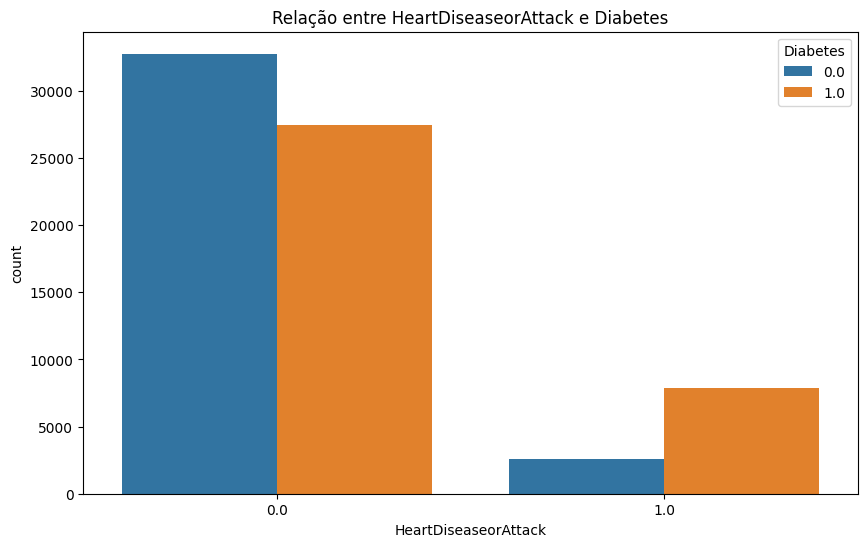


Tabela de contingência entre PhysActivity e Diabetes:
Diabetes        0.0    1.0
PhysActivity              
0.0            7934  13059
1.0           27412  22287
Chi-square: 1778.96, p-value: 0.0000
A variável PhysActivity tem relação estatisticamente significativa com Diabetes (p<0.05)


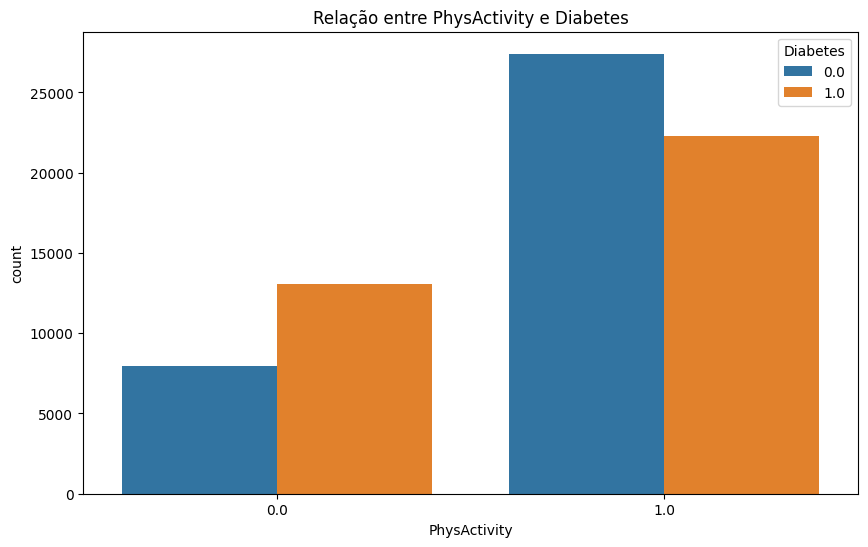


Tabela de contingência entre Fruits e Diabetes:
Diabetes    0.0    1.0
Fruits                
0.0       12790  14653
1.0       22556  20693
Chi-square: 206.50, p-value: 0.0000
A variável Fruits tem relação estatisticamente significativa com Diabetes (p<0.05)


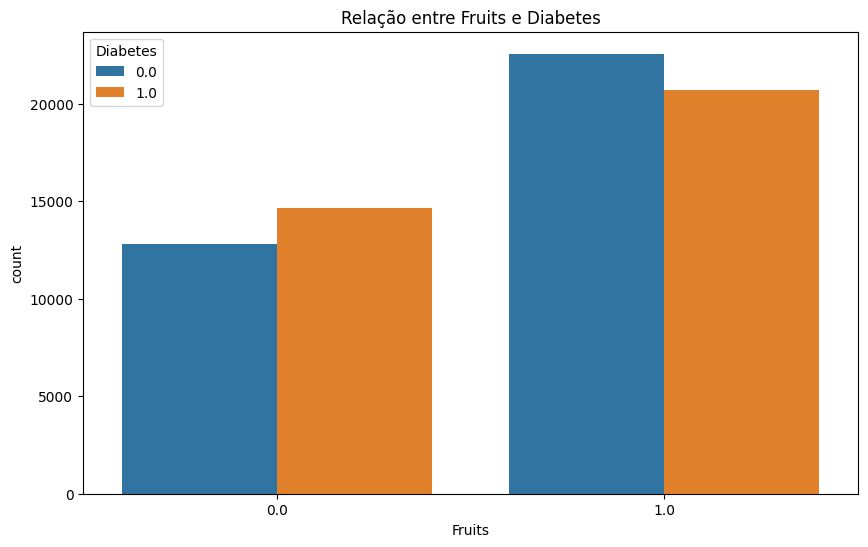


Tabela de contingência entre Veggies e Diabetes:
Diabetes    0.0    1.0
Veggies               
0.0        6322   8610
1.0       29024  26736
Chi-square: 444.08, p-value: 0.0000
A variável Veggies tem relação estatisticamente significativa com Diabetes (p<0.05)


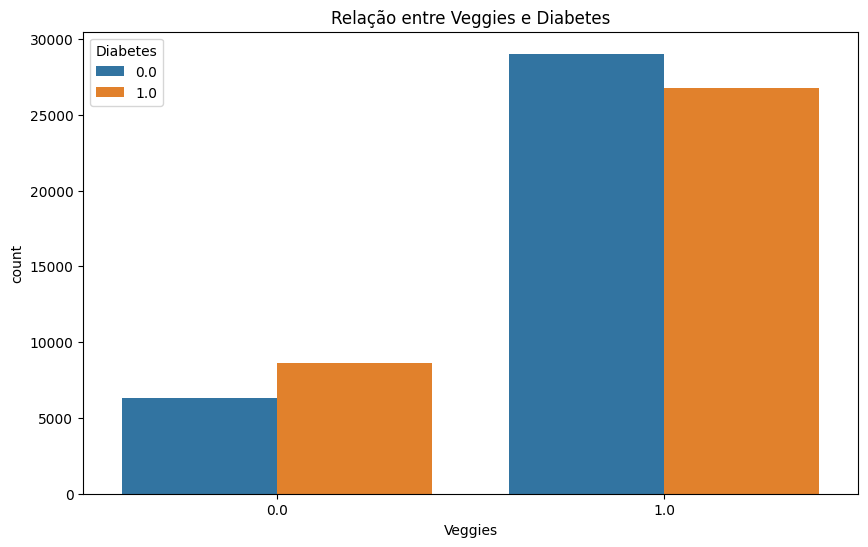


Tabela de contingência entre HvyAlcoholConsump e Diabetes:
Diabetes             0.0    1.0
HvyAlcoholConsump              
0.0                33158  34514
1.0                 2188    832
Chi-square: 635.09, p-value: 0.0000
A variável HvyAlcoholConsump tem relação estatisticamente significativa com Diabetes (p<0.05)


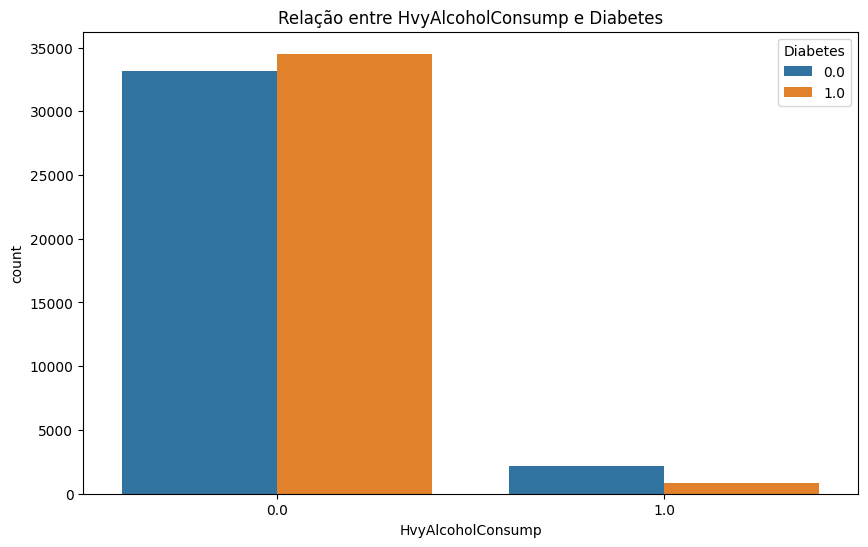


Tabela de contingência entre GenHlth e Diabetes:
Diabetes    0.0    1.0
GenHlth               
1.0        7142   1140
2.0       13491   6381
3.0        9970  13457
4.0        3513   9790
5.0        1230   4578
Chi-square: 12304.32, p-value: 0.0000
A variável GenHlth tem relação estatisticamente significativa com Diabetes (p<0.05)


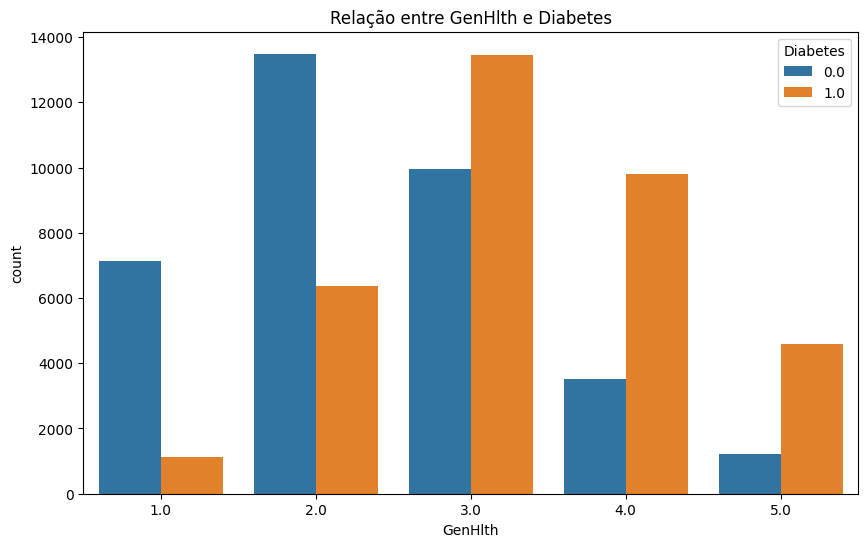


Tabela de contingência entre DiffWalk e Diabetes:
Diabetes    0.0    1.0
DiffWalk              
0.0       30601  22225
1.0        4745  13121
Chi-square: 5253.69, p-value: 0.0000
A variável DiffWalk tem relação estatisticamente significativa com Diabetes (p<0.05)


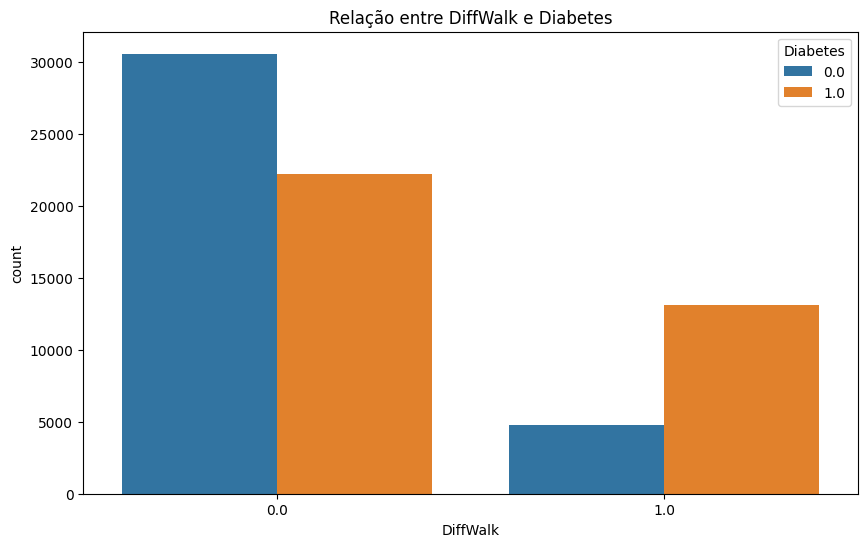


Tabela de contingência entre Stroke e Diabetes:
Diabetes    0.0    1.0
Stroke                
0.0       34219  32078
1.0        1127   3268
Chi-square: 1111.08, p-value: 0.0000
A variável Stroke tem relação estatisticamente significativa com Diabetes (p<0.05)


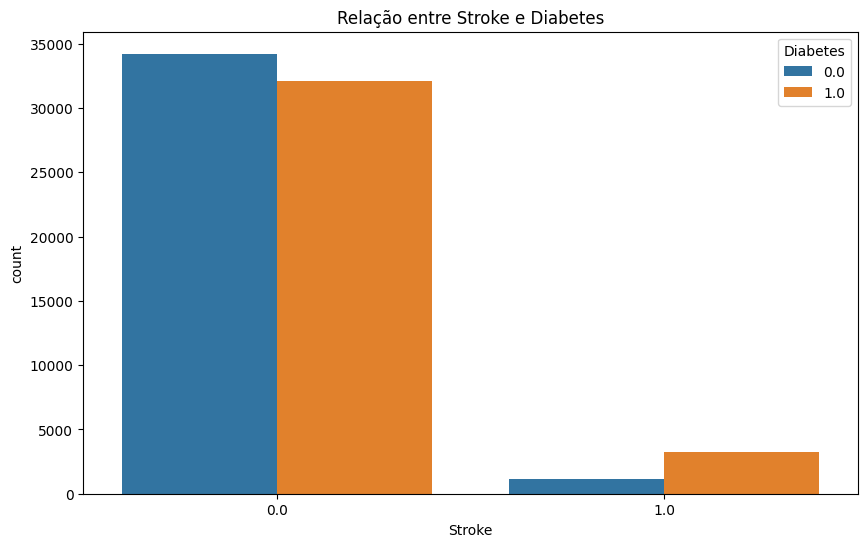


Tabela de contingência entre HighBP e Diabetes:
Diabetes    0.0    1.0
HighBP                
0.0       22118   8742
1.0       13228  26604
Chi-square: 10287.97, p-value: 0.0000
A variável HighBP tem relação estatisticamente significativa com Diabetes (p<0.05)


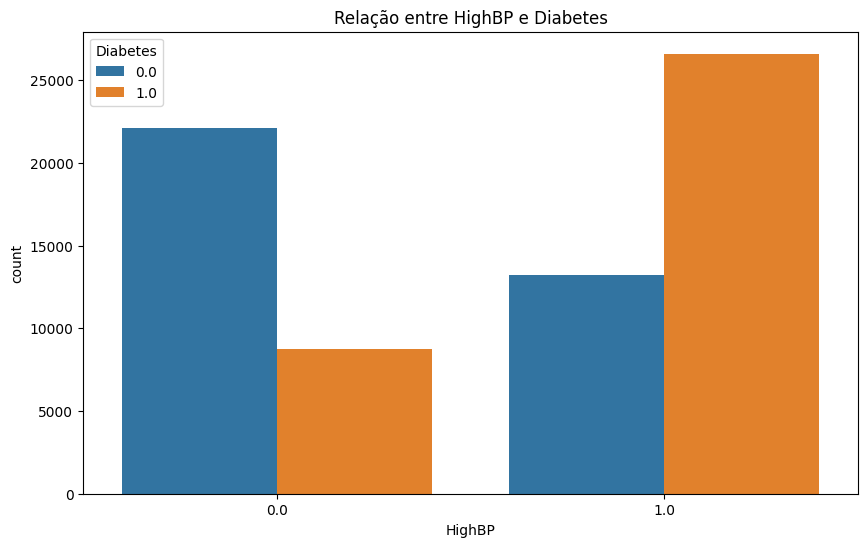


Estatísticas de Age por grupo de Diabetes:
            count      mean       std  min  25%   50%   75%   max
Diabetes                                                         
0.0       35346.0  7.789057  3.094436  1.0  6.0   8.0  10.0  13.0
1.0       35346.0  9.379053  2.330273  1.0  8.0  10.0  11.0  13.0
T-statistic: 77.17, p-value: 0.0000
A diferença nas médias de Age entre os grupos é estatisticamente significativa (p<0.05)


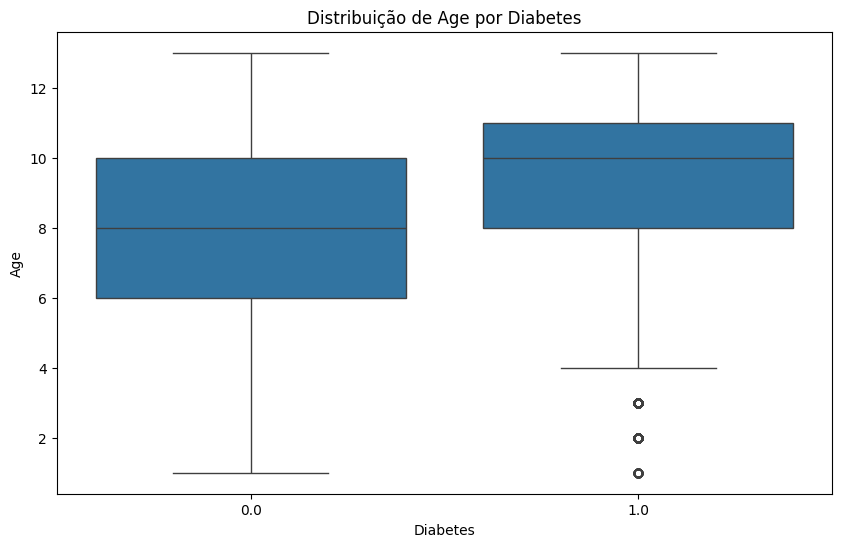


Estatísticas de BMI por grupo de Diabetes:
            count       mean       std   min   25%   50%   75%   max
Diabetes                                                            
0.0       35346.0  27.769960  6.187636  12.0  24.0  27.0  31.0  98.0
1.0       35346.0  31.944011  7.363401  13.0  27.0  31.0  35.0  98.0
T-statistic: 81.59, p-value: 0.0000
A diferença nas médias de BMI entre os grupos é estatisticamente significativa (p<0.05)


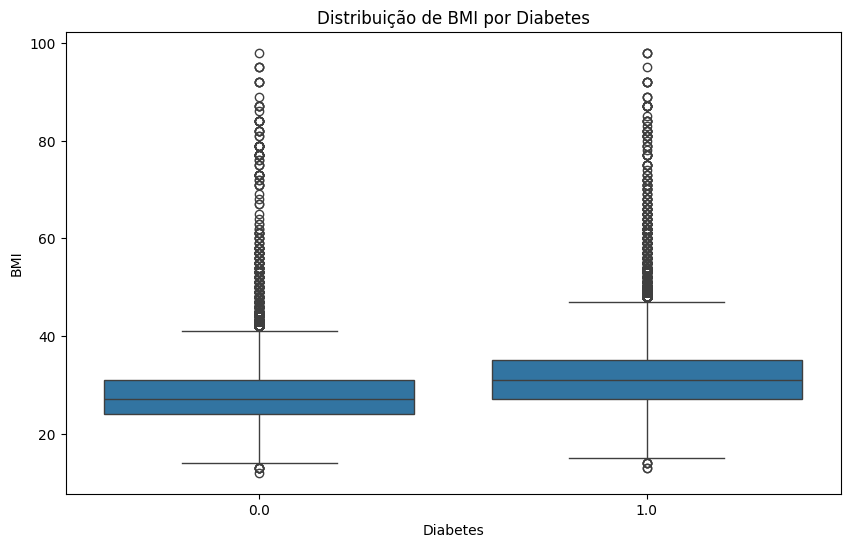


Estatísticas de MentHlth por grupo de Diabetes:
            count      mean       std  min  25%  50%  75%   max
Diabetes                                                       
0.0       35346.0  3.042268  7.208408  0.0  0.0  0.0  2.0  30.0
1.0       35346.0  4.461806  8.947717  0.0  0.0  0.0  3.0  30.0
T-statistic: 23.23, p-value: 0.0000
A diferença nas médias de MentHlth entre os grupos é estatisticamente significativa (p<0.05)


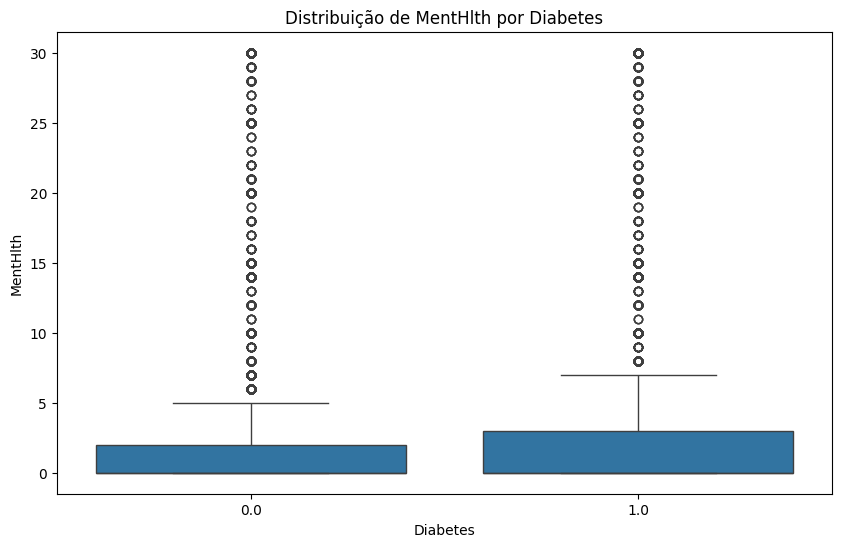


Estatísticas de PhysHlth por grupo de Diabetes:
            count      mean        std  min  25%  50%   75%   max
Diabetes                                                         
0.0       35346.0  3.666355   8.098339  0.0  0.0  0.0   2.0  30.0
1.0       35346.0  7.954479  11.301491  0.0  0.0  1.0  15.0  30.0
T-statistic: 57.98, p-value: 0.0000
A diferença nas médias de PhysHlth entre os grupos é estatisticamente significativa (p<0.05)


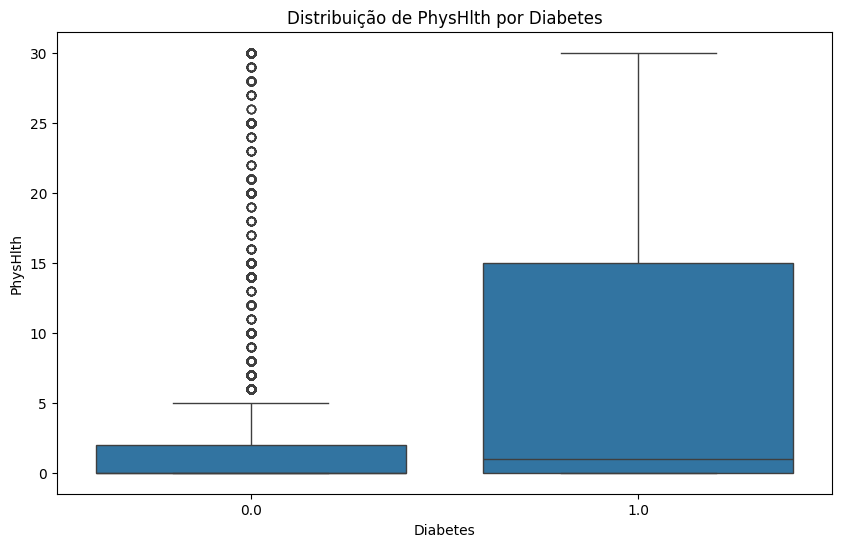

In [ ]:
# Para variáveis categóricas: tabelas de contingência
for col in categorical_cols:
    if col != 'Diabetes':
        print(f"\nTabela de contingência entre {col} e Diabetes:")
        contingency_table = pd.crosstab(df[col], df['Diabetes'])
        print(contingency_table)

        # Chi-square test
        chi2, p, _, _ = stats.chi2_contingency(contingency_table)
        print(f"Chi-square: {chi2:.2f}, p-value: {p:.4f}")
        if p < 0.05:
            print(f"A variável {col} tem relação estatisticamente significativa com Diabetes (p<0.05)")
        else:
            print(f"A variável {col} NÃO tem relação estatisticamente significativa com Diabetes (p>=0.05)")

        # Visualização
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue='Diabetes', data=df)
        plt.title(f'Relação entre {col} e Diabetes')
        # plt.savefig(f'{col}_vs_stroke.png')
        plt.show()
        plt.close()

# Para variáveis numéricas: análise por grupo
for col in numerical_cols:
    print(f"\nEstatísticas de {col} por grupo de Diabetes:")
    print(df.groupby('Diabetes')[col].describe())

    # T-test para comparar médias
    stroke_yes = df[df['Diabetes'] == 1][col]
    stroke_no = df[df['Diabetes'] == 0][col]
    t_stat, p_val = stats.ttest_ind(stroke_yes, stroke_no, equal_var=False)
    print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")
    if p_val < 0.05:
        print(f"A diferença nas médias de {col} entre os grupos é estatisticamente significativa (p<0.05)")
    else:
        print(f"A diferença nas médias de {col} entre os grupos NÃO é estatisticamente significativa (p>=0.05)")

    # Visualização
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Diabetes', y=col, data=df)
    plt.title(f'Distribuição de {col} por Diabetes')
    # plt.savefig(f'C:/Users/gabri/Downloads/Diabetes/{col}_by_stroke.png')
    plt.show()
    plt.close()

### Análise de Correlação

Correlação de cada variável com Diabetes:
Diabetes                1.000000
GenHlth                 0.407612
HighBP                  0.381516
BMI                     0.293373
HighChol                0.289213
Age                     0.278738
DiffWalk                0.272646
PhysHlth                0.213081
HeartDiseaseorAttack    0.211523
Stroke                  0.125427
CholCheck               0.115382
MentHlth                0.087029
Smoker                  0.085999
Sex                     0.044413
Fruits                 -0.054077
Veggies                -0.079293
HvyAlcoholConsump      -0.094853
PhysActivity           -0.158666
Name: Diabetes, dtype: float64


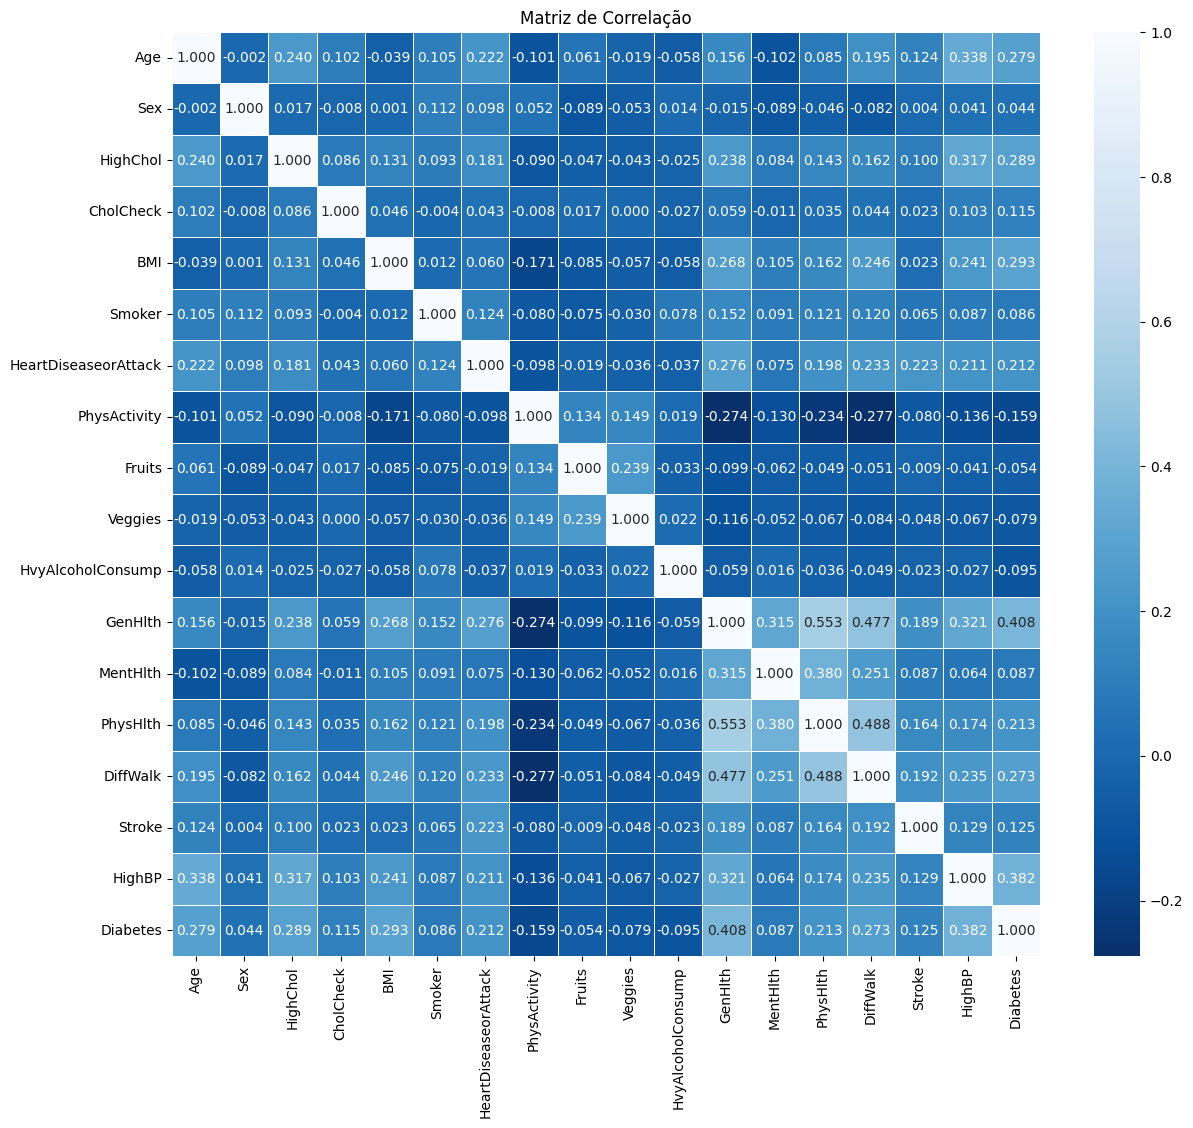

In [ ]:
# Convertendo variáveis categóricas para numéricas para cálculo de correlação
df_corr = df.copy()
for col in categorical_cols:
    if df_corr[col].nunique() <= 2:  # Para variáveis binárias
        pass  # Já são 0 e 1, não precisamos converter
    else:  # Para variáveis categóricas com mais de 2 categorias
        le = LabelEncoder()
        df_corr[col] = le.fit_transform(df_corr[col])

# Calculando a matriz de correlação
correlation_matrix = df_corr.corr()

# Ordenando correlações com a variável alvo
target_correlations = correlation_matrix['Diabetes'].sort_values(ascending=False)
print("Correlação de cada variável com Diabetes:")
print(target_correlations)

# Visualizando a matriz de correlação
plt.figure(figsize=(14, 12))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5)
sns.heatmap(correlation_matrix, annot=True, cmap='Blues_r', fmt='.3f', linewidths=0.5)
plt.title('Matriz de Correlação')
# plt.savefig('correlation_matrix.png')
# print("Matriz de correlação salva como 'correlation_matrix.png'")
plt.show()
plt.close()



### Conclusão

In [ ]:
# Identificando variáveis com baixa correlação com a variável alvo
low_corr_threshold = 0.05
low_corr_vars = target_correlations[abs(target_correlations) < low_corr_threshold].index.tolist()
if 'Diabetes' in low_corr_vars:
    low_corr_vars.remove('Diabetes')

print("Variáveis com baixa correlação com Diabetes (abaixo de 0.05):")
print(low_corr_vars)

# Identificando variáveis altamente correlacionadas entre si (multicolinearidade)
high_corr_threshold = 0.7
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

if high_corr_pairs:
    print("\nPares de variáveis altamente correlacionadas (potencial multicolinearidade):")
    for var1, var2, corr in high_corr_pairs:
        print(f"{var1} e {var2}: {corr:.2f}")

# Recomendações baseadas na análise
print("\nRecomendações com base na análise:")
if len(low_corr_vars) > 0:
    print(f"- Considere remover as variáveis com baixa correlação: {', '.join(low_corr_vars)}")
if high_corr_pairs:
    print("- Avalie a possibilidade de remover uma variável de cada par altamente correlacionado")

if imbalance_ratio > 10:
    print("- O dataset está muito desbalanceado. Considere técnicas como:")
    print("  * SMOTE (Synthetic Minority Over-sampling Technique)")
    print("  * Random Under-sampling da classe majoritária")
    print("  * Ajuste de pesos no modelo")

print("\nVariáveis mais importantes para predição de AVC (baseado na correlação):")
top_features = target_correlations[target_correlations.index != 'Diabetes'].abs().sort_values(ascending=False).head(5).index.tolist()
for i, feature in enumerate(top_features):
    corr_value = target_correlations[feature]
    print(f"{i+1}. {feature}: {corr_value:.4f}")

Variáveis com baixa correlação com Diabetes (abaixo de 0.05):
['Sex']

Recomendações com base na análise:
- Considere remover as variáveis com baixa correlação: Sex

Variáveis mais importantes para predição de AVC (baseado na correlação):
1. GenHlth: 0.4076
2. HighBP: 0.3815
3. BMI: 0.2934
4. HighChol: 0.2892
5. Age: 0.2787


# Preparação dos dados para os modelos

## Feature Engineering

In [ ]:
# Como visto na análise, retiramos a(s) variável(eis) com baixa correlação com a variável alvo
data = df.drop(['Sex'], axis=1)
data.head()

,Age,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Separamos os dados entre atributos e a variável-alvo
X = data.drop('Diabetes', axis = 1)
y = data['Diabetes']

## Train-Test-Split e Scaling

In [ ]:
# Separamos os dados entre o conjunto de treino e o conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=105, stratify=y)

In [ ]:
# Imprimindo as dimensões de cada conjunto de dados
print(X_train.shape)
print(X_test.shape)

(49484, 16)
(21208, 16)


In [ ]:
# Certificando que temos arrays e não DataFrames para indexação com [train_idx]
X_train_array = X_train if isinstance(X_train, np.ndarray) else X_train.to_numpy()
y_train_array = y_train if isinstance(y_train, np.ndarray) else y_train.to_numpy()
X_test_array = X_test if isinstance(X_test, np.ndarray) else X_test.to_numpy()
y_test_array = y_test if isinstance(y_test, np.ndarray) else y_test.to_numpy()

## Modelo Generico

In [ ]:
# Função Generalizada para Executar um Modelo
def model_cross_val(model, X, y, cv=5, show_confusion_matrix=False):
    print(f"\n=== {model.__class__.__name__} ===")
    # Cria uma instância de StratifiedKFold para validação cruzada estratificada
    # Isso garante que cada divisão (fold) tenha aproximadamente a mesma proporção de classes (útil em dados desbalanceados)
    # cv define o número de dobras (folds), shuffle embaralha os dados antes de dividir, e random_state fixa a aleatoriedade
    skf = StratifiedKFold(n_splits = cv, shuffle=True, random_state = 42)

    # Inicializa listas vazias para armazenar as métricas de avaliação de cada fold
    accs, f1s, precs, recalls, aucs = [], [], [], [], []

    # Cria uma grade de 100 valores entre 0 e 1, que será usada para interpolar as curvas ROC
    # e assim poder calcular a média das curvas de todos os folds.
    mean_fpr = np.linspace(0, 1, 100)

    # Lista para armazenar os valores de TPR (taxa de verdadeiros positivos) interpolados de cada fold.
    tprs = []

    # Para matriz de confusão agregada
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        # Separar dados do fold
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]

        # Mudando a escala de algumas entradas uma vez que valores maiores podem enviesar o modelo
        scaler = StandardScaler()
        X_fold_train_scaled = scaler.fit_transform(X_fold_train)
        X_fold_val_scaled = scaler.transform(X_fold_val)

        # Treinar e predizer
        model.fit(X_fold_train_scaled, y_fold_train)
        y_pred = model.predict(X_fold_val_scaled)

        # Armazenar para matriz de confusão agregada
        all_y_true.extend(y_fold_val)
        all_y_pred.extend(y_pred)

        # Calcular métricas
        accs.append(accuracy_score(y_fold_val, y_pred))
        f1s.append(f1_score(y_fold_val, y_pred, zero_division=0))
        precs.append(precision_score(y_fold_val, y_pred, zero_division=0))
        recalls.append(recall_score(y_fold_val, y_pred, zero_division=0))

        # Probabilidades para AUC/ROC
        try:
            y_score = model.predict_proba(X_fold_val_scaled)[:, 1]
        except AttributeError:
            # Para modelos como SVC com decision_function
            y_score = model.decision_function(X_fold_val_scaled)

        fpr, tpr, _ = roc_curve(y_fold_val, y_score)
        aucs.append(roc_auc_score(y_fold_val, y_score))
        tprs.append(np.interp(mean_fpr, fpr, tpr))

    # Resultados finais
    print(f"Acurácia média: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
    print(f"F1 média:       {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
    print(f"Precisão média: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
    print(f"Recall médio:   {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
    print(f"AUC média:      {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

    # Matriz de confusão agregada de todos os folds
    if show_confusion_matrix:
        plt.figure(figsize=(6, 5))
        ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, cmap='Blues')
        plt.title(f'Matriz de Confusão Agregada - {model.__class__.__name__}')
        plt.show()

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)

    plt.plot(mean_fpr, mean_tpr, label=f"ROC (AUC = {np.mean(aucs):.3f} ± {np.std(aucs):.3f})")
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, alpha=0.2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model.__class__.__name__}")
    plt.legend()
    plt.grid()
    plt.show()

    # Retorno as médias de cada métrica obtida
    return {
        'accuracy': np.mean(accs),
        'f1': np.mean(f1s),
        'precision': np.mean(precs),
        'recall': np.mean(recalls),
        'auc': np.mean(aucs)
    }


## Testing Different Models

In [ ]:
# Função que realiza o Grid Search para otimização dos parâmetros
def grid_search_with_cv(model, param_grid, X, y, cv=5, scoring='recall'):
    print(f"\n=== Grid Search - {model.__class__.__name__} ===")

    # Normalizar os dados de treino (apenas uma vez para o Grid Search)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Grid Search com CV interna
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,  # Usamos Recall para evitar Falsos Negativos
        verbose=1,
        n_jobs=-1,
        error_score='raise'
    )

    grid_search.fit(X_scaled, y)

    print(f"Melhores parâmetros: {grid_search.best_params_}")
    print(f"Melhor score ({scoring}): {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

In [ ]:
# Dicionário para fazer a avaliação com CV corrigida
resultados = {}

# Dicionário para realizar Grid Search para cada modelo
melhores_modelos = {}


### LOGISTIC REGRESSION

#### Testando o modelo com parâmetros default


=== LogisticRegression ===
Acurácia média: 0.7467 ± 0.0030
F1 média:       0.7517 ± 0.0026
Precisão média: 0.7371 ± 0.0046
Recall médio:   0.7670 ± 0.0049
AUC média:      0.8224 ± 0.0034


<Figure size 600x500 with 0 Axes>

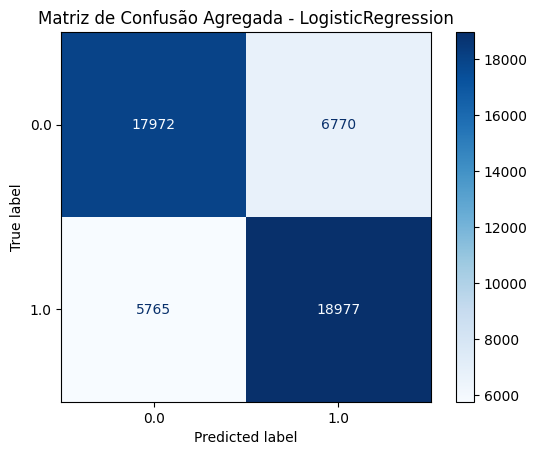

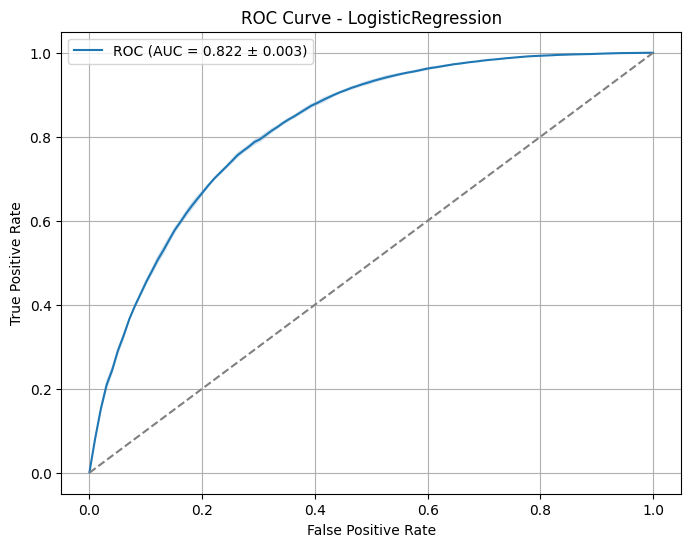

In [ ]:
# Definindo o modelo a ser testado
modelo = LogisticRegression()

# Executo o modelo com parâmetros default
_ = model_cross_val(modelo, X_train_array, y_train_array, show_confusion_matrix=True)

#### Testando o modelo após usar GridSearchCV

In [ ]:
# Definindo parâmetros para o GridSearchCV
param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000],
        'class_weight': ['balanced', None]
    }

# Chamando a função do Grid Search
melhor_modelo = grid_search_with_cv(
    modelo,
    param_grid,
    X_train_array,
    y_train_array,
    cv=5
)

# Salvando o modelo com parâmetros otimizados
melhores_modelos['LogisticRegression'] = melhor_modelo


=== Grid Search - LogisticRegression ===
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Melhores parâmetros: {'C': 0.01, 'class_weight': None, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}
Melhor score (recall): 0.7706



=== LogisticRegression ===
Acurácia média: 0.7468 ± 0.0036
F1 média:       0.7528 ± 0.0032
Precisão média: 0.7356 ± 0.0050
Recall médio:   0.7709 ± 0.0049
AUC média:      0.8222 ± 0.0033


<Figure size 600x500 with 0 Axes>

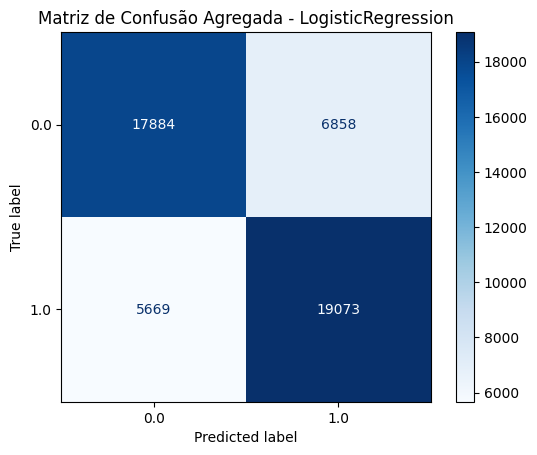

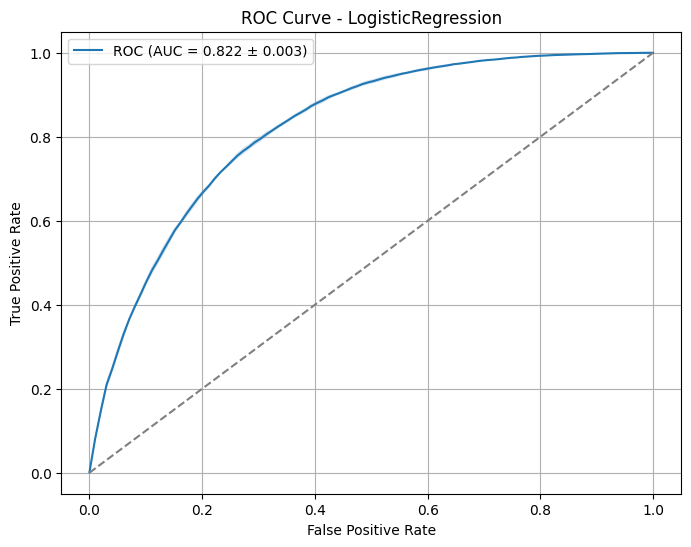

In [ ]:
# Parâmetros obtidos pelo Grid Search
# melhor_modelo = LogisticRegression(C=0.01, class_weight=None, max_iter=2000, penalty='l1', solver='liblinear')

# Salvando os resultados do modelo otimizado
resultados["LogisticRegression"] = model_cross_val(melhor_modelo, X_train_array, y_train_array, show_confusion_matrix=True)

### DECISION TREE

#### Testando o modelo com parâmetros default


=== DecisionTreeClassifier ===
Acurácia média: 0.6581 ± 0.0047
F1 média:       0.6497 ± 0.0049
Precisão média: 0.6660 ± 0.0054
Recall médio:   0.6342 ± 0.0060
AUC média:      0.6628 ± 0.0051


<Figure size 600x500 with 0 Axes>

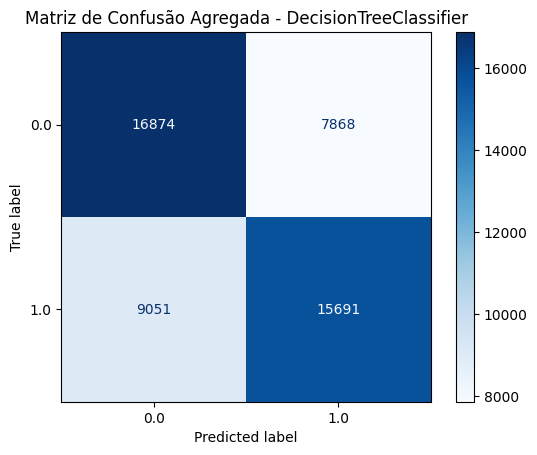

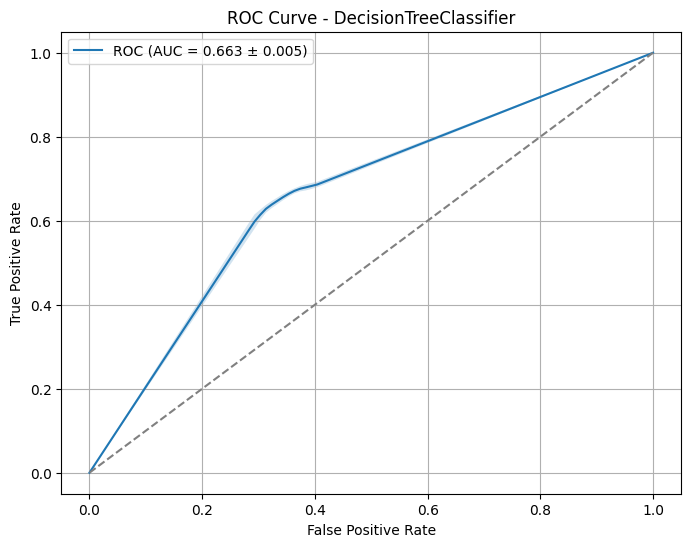

In [ ]:
# Definindo o modelo a ser testado
modelo = DecisionTreeClassifier()

# Executo o modelo com parâmetros default
_ = model_cross_val(modelo, X_train_array, y_train_array, show_confusion_matrix=True)

#### Testando o modelo após usar GridSearchCV

In [ ]:
# Definindo parâmetros para o GridSearchCV
param_grid = {
        'max_features': ['sqrt', 'log2', None],
        'ccp_alpha': [0.001, 0.01, 0.1],
        'max_depth': [5, 6, 7, 8, 9, 10],
        'criterion': ['gini', 'entropy'],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

# Chamando a função do Grid Search
melhor_modelo = grid_search_with_cv(
    modelo,
    param_grid,
    X_train_array,
    y_train_array,
    cv=5,
)

# Salvando o modelo com parâmetros otimizados
melhores_modelos['DecisionTreeClassifier'] = melhor_modelo


=== Grid Search - DecisionTreeClassifier ===
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Melhores parâmetros: {'ccp_alpha': 0.1, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
Melhor score (recall): 0.8651



=== DecisionTreeClassifier ===
Acurácia média: 0.6135 ± 0.0927
F1 média:       0.5622 ± 0.2817
Precisão média: 0.4963 ± 0.2558
Recall médio:   0.6675 ± 0.3448
AUC média:      0.6135 ± 0.0927


<Figure size 600x500 with 0 Axes>

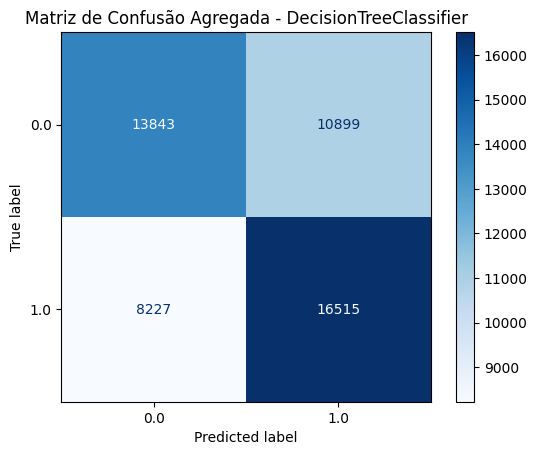

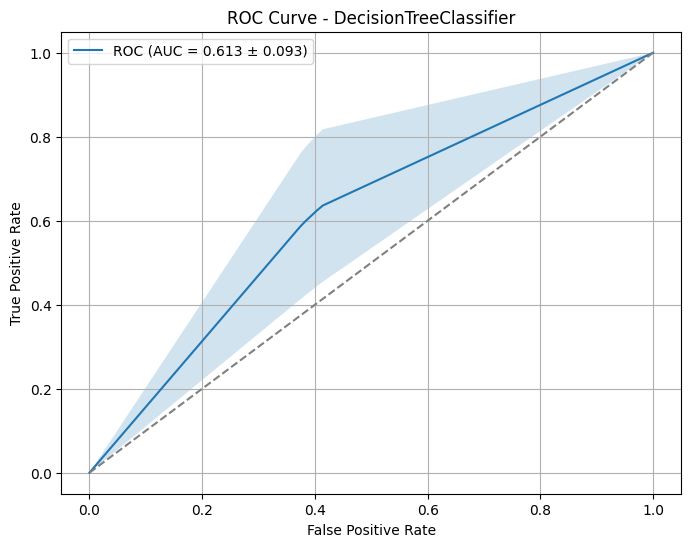

In [ ]:
# Parâmetros obtidos pelo Grid Search
# melhor_modelo = DecisionTreeClassifier(ccp_alpha=0.1, criterion='entropy', 
#                                        max_depth=8, max_features='sqrt, 
#                                        min_samples_leaf=2, min_samples_split=2)

# Salvando os resultados do modelo otimizado
resultados["DecisionTreeClassifier"] = model_cross_val(melhor_modelo, X_train_array, y_train_array, show_confusion_matrix=True)

### RANDOM FOREST

#### Testando o modelo com parâmetros default


=== RandomForestClassifier ===
Acurácia média: 0.7203 ± 0.0038
F1 média:       0.7292 ± 0.0031
Precisão média: 0.7067 ± 0.0047
Recall médio:   0.7531 ± 0.0027
AUC média:      0.7871 ± 0.0043


<Figure size 600x500 with 0 Axes>

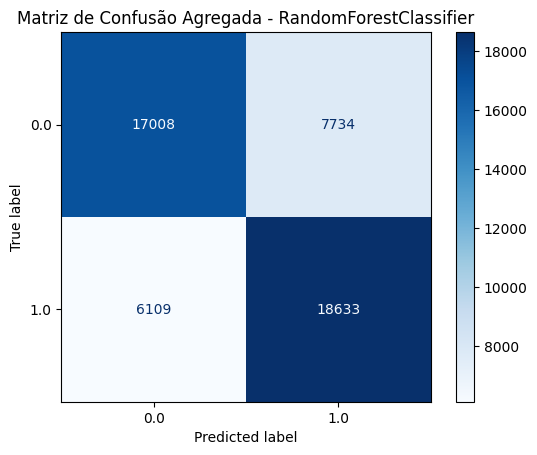

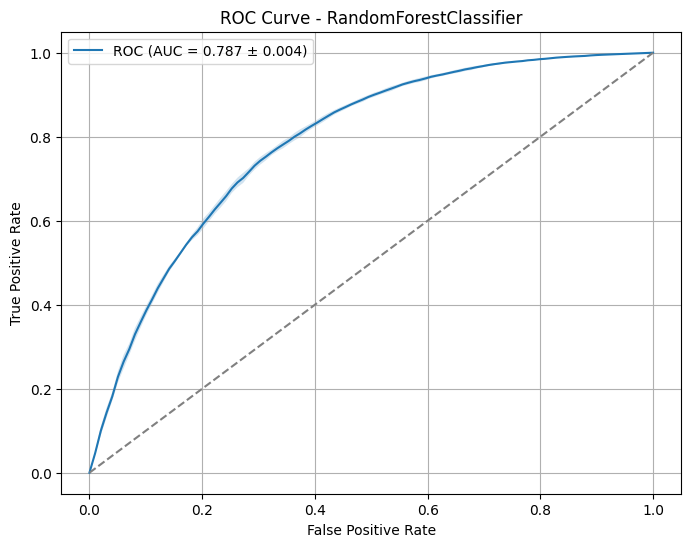

In [ ]:
# Definindo o modelo a ser testado
modelo = RandomForestClassifier()

# Executo o modelo com parâmetros default
_ = model_cross_val(modelo, X_train_array, y_train_array, show_confusion_matrix=True)

#### Testando o modelo após usar GridSearchCV

In [ ]:
# Definindo parâmetros para o GridSearchCV
param_grid = {
        'n_estimators': [100, 200, 300],
        'max_features': ['sqrt', 'log2'],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

# Chamando a função do Grid Search
melhor_modelo = grid_search_with_cv(
    modelo,
    param_grid,
    X_train_array,
    y_train_array,
    cv=5
)

# Salvando o modelo com parâmetros otimizados
melhores_modelos['RandomForestClassifier'] = melhor_modelo


=== Grid Search - RandomForestClassifier ===
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Melhores parâmetros: {'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Melhor score (recall): 0.7861



=== RandomForestClassifier ===
Acurácia média: 0.7434 ± 0.0033
F1 média:       0.7537 ± 0.0019
Precisão média: 0.7246 ± 0.0052
Recall médio:   0.7852 ± 0.0024
AUC média:      0.8209 ± 0.0029


<Figure size 600x500 with 0 Axes>

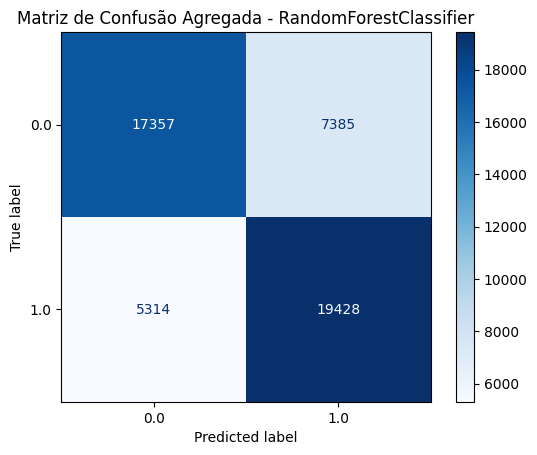

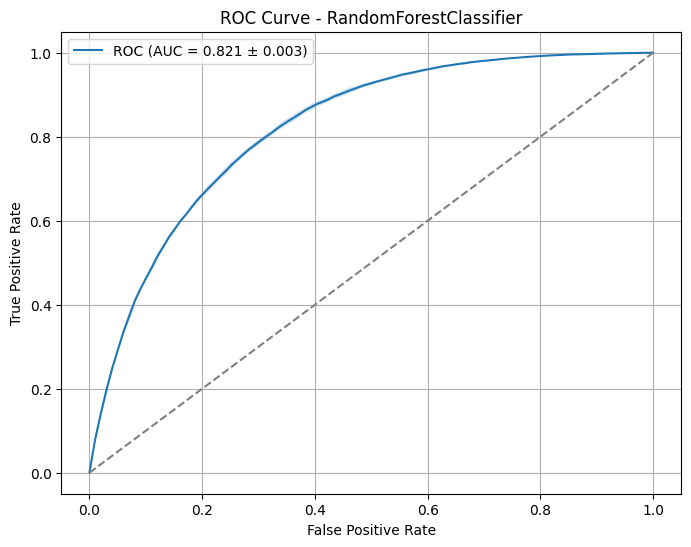

In [ ]:
# Parâmetros obtidos pelo Grid Search
# melhor_modelo = DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=4, min_samples_split=10, n_estimators=300)

# Salvando os resultados do modelo otimizado
resultados["RandomForestClassifier"] = model_cross_val(melhor_modelo, X_train_array, y_train_array, show_confusion_matrix=True)

### PERCEPTRON

#### Testando o modelo com parâmetros default


=== Perceptron ===
Acurácia média: 0.6484 ± 0.0532
F1 média:       0.6218 ± 0.0939
Precisão média: 0.6648 ± 0.0538
Recall médio:   0.6027 ± 0.1594
AUC média:      0.6942 ± 0.0931


<Figure size 600x500 with 0 Axes>

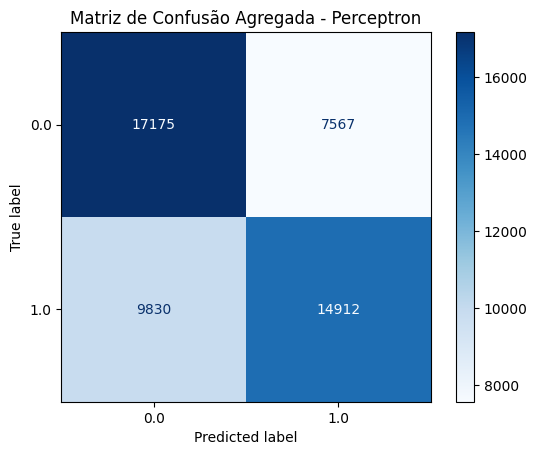

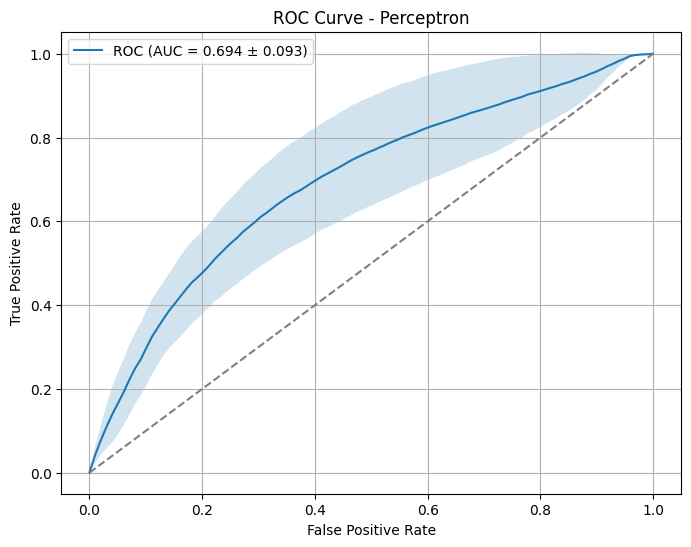

In [ ]:
# Definindo o modelo a ser testado
modelo = Perceptron()

# Executo o modelo com parâmetros default
_ = model_cross_val(modelo, X_train_array, y_train_array, show_confusion_matrix=True)

#### Testando o modelo após usar GridSearchCV

In [ ]:
# Definindo parâmetros para o GridSearchCV
param_grid = {
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'penalty': ['l2', 'l1', 'elasticnet'],
        'max_iter': [1000, 2000, 3000]
    }

# Chamando a função do Grid Search
melhor_modelo = grid_search_with_cv(
    modelo,
    param_grid,
    X_train_array,
    y_train_array,
    cv=5
)

# Salvando o modelo com parâmetros otimizados
melhores_modelos['Perceptron'] = melhor_modelo


=== Grid Search - Perceptron ===
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Melhores parâmetros: {'alpha': 0.1, 'max_iter': 1000, 'penalty': 'elasticnet'}
Melhor score (recall): 0.8598



=== Perceptron ===
Acurácia média: 0.5984 ± 0.0572
F1 média:       0.4426 ± 0.2496
Precisão média: 0.5468 ± 0.2800
Recall médio:   0.4169 ± 0.2852
AUC média:      0.6614 ± 0.0852


<Figure size 600x500 with 0 Axes>

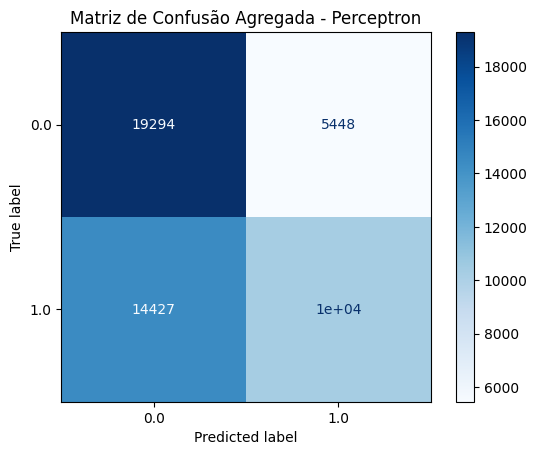

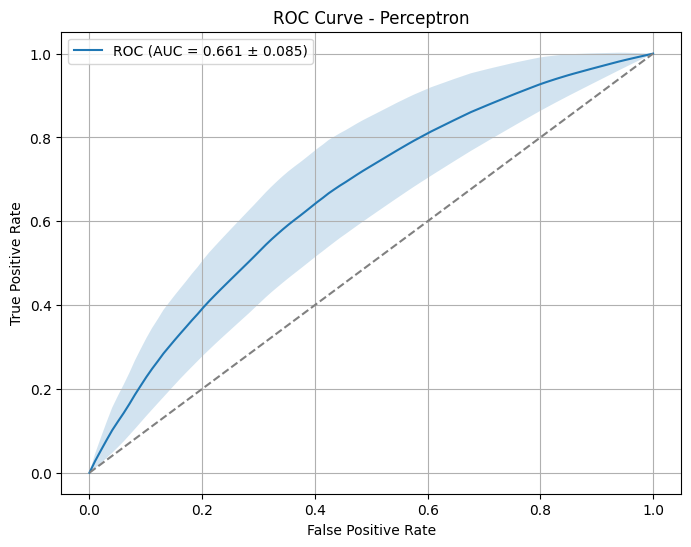

In [ ]:
# Parâmetros obtidos pelo Grid Search
# melhor_modelo = Perceptron(alpha=0.1, max_iter=1000, penalty='elasticnet)')

# Salvando os resultados do modelo otimizado
resultados["Perceptron"] = model_cross_val(melhor_modelo, X_train_array, y_train_array, show_confusion_matrix=True)

### SVM

#### Testando o modelo com parâmetros default


=== SVC ===
Acurácia média: 0.7451 ± 0.0028
F1 média:       0.7575 ± 0.0017
Precisão média: 0.7225 ± 0.0048
Recall médio:   0.7961 ± 0.0040
AUC média:      0.8109 ± 0.0043


<Figure size 600x500 with 0 Axes>

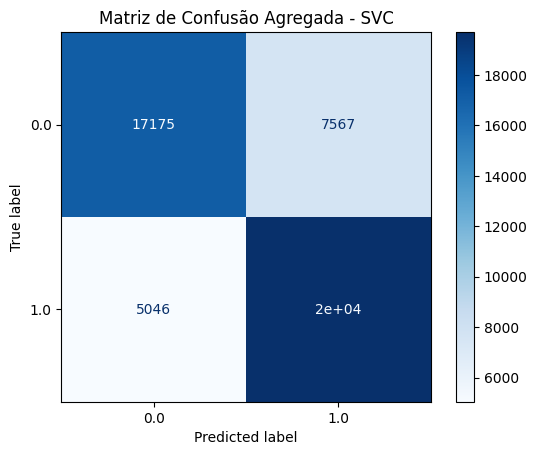

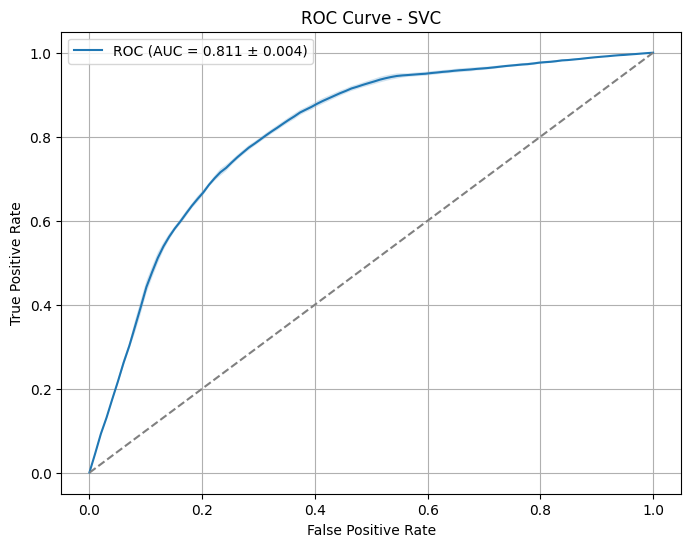

In [ ]:
# Definindo o modelo a ser testado
modelo = SVC(probability=True)

# Executo o modelo com parâmetros default
_ = model_cross_val(modelo, X_train_array, y_train_array, show_confusion_matrix=True)

#### Testanto o modelo após usar GridSearchCV

In [ ]:
# Definindo parâmetros para o GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
	'gamma': [0.1, 0.01, 0.001]
    }

# Chamando a função do Grid Search
melhor_modelo = grid_search_with_cv(
    modelo,
    param_grid,
    X_train_array,
    y_train_array,
    cv=5
)

# Salvando o modelo com parâmetros otimizados
melhores_modelos['SVM'] = melhor_modelo


=== Grid Search - SVC ===
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Melhores parâmetros: {'C': 1, 'gamma': 0.01}
Melhor score (recall): 0.8237



=== SVC ===
Acurácia média: 0.7475 ± 0.0029
F1 média:       0.7651 ± 0.0020
Precisão média: 0.7154 ± 0.0041
Recall médio:   0.8222 ± 0.0030
AUC média:      0.8235 ± 0.0035


<Figure size 600x500 with 0 Axes>

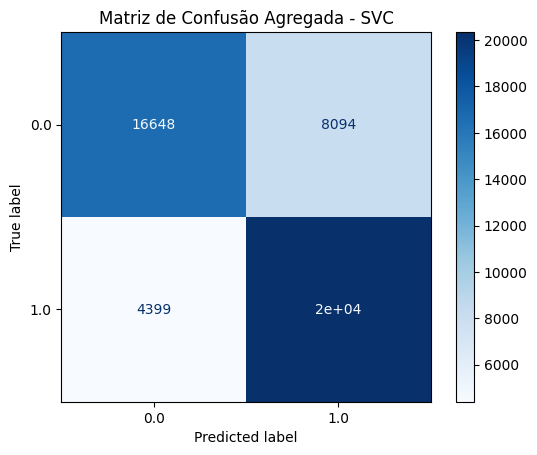

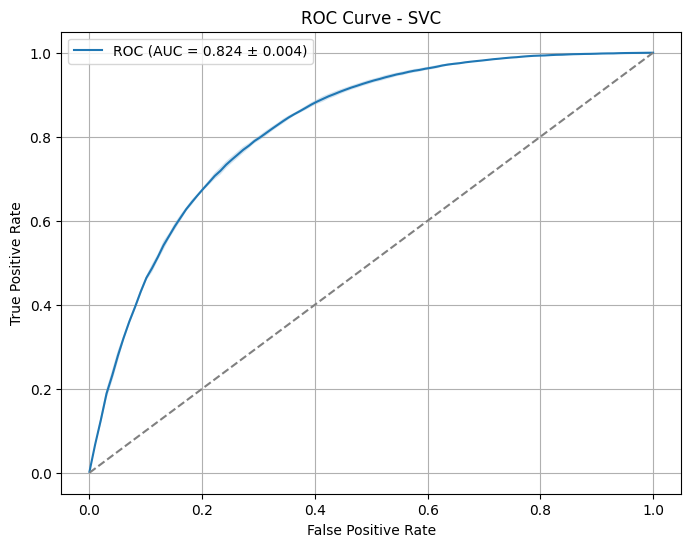

In [ ]:
# Parâmetros obtidos pelo Grid Search
# melhor_modelo = SVC(C=1, gamma=0.1, probability=True)

# Salvando os resultados do modelo otimizado
resultados["SVM"] = model_cross_val(melhor_modelo, X_train_array, y_train_array, show_confusion_matrix=True)

### Gradient Boosting

#### Testando o modelo com parâmetros default


=== GradientBoostingClassifier ===
Acurácia média: 0.7497 ± 0.0037
F1 média:       0.7599 ± 0.0026
Precisão média: 0.7302 ± 0.0053
Recall médio:   0.7923 ± 0.0025
AUC média:      0.8275 ± 0.0038


<Figure size 600x500 with 0 Axes>

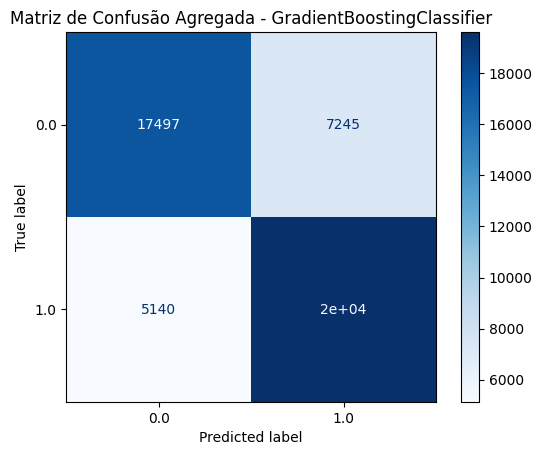

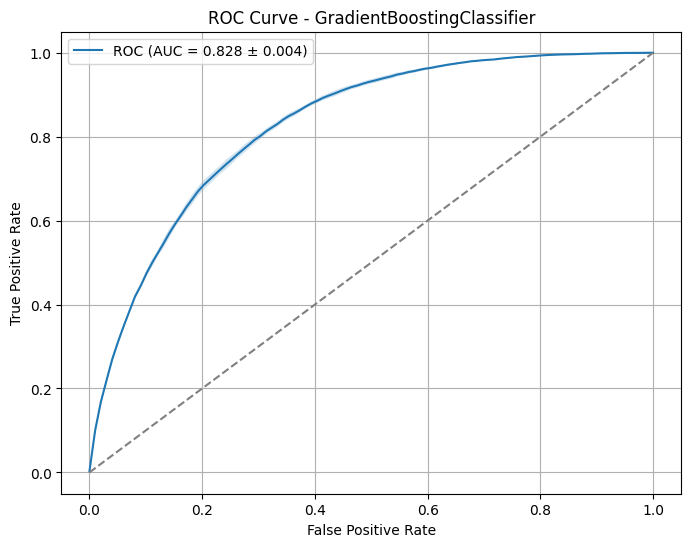

In [ ]:
# Definindo o modelo a ser testado
modelo = GradientBoostingClassifier()

# Executo o modelo com parâmetros default
_ = model_cross_val(modelo, X_train_array, y_train_array, show_confusion_matrix=True)

#### Testando o modelo após usar GridSearchCV

In [ ]:
# Definindo parâmetros para o GridSearchCV
param_grid = {
    "learning_rate": [0.05, 0.1, 0.5, 1],
    "min_samples_split": [2, 4],
    "min_samples_leaf": [1, 2],
    }

# Chamando a função do Grid Search
melhor_modelo = grid_search_with_cv(
    modelo,
    param_grid,
    X_train_array,
    y_train_array,
    cv=5
)

# Salvando o modelo com parâmetros otimizados
melhores_modelos['Gradiente Boosting'] = melhor_modelo


=== Grid Search - GradientBoostingClassifier ===
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Melhores parâmetros: {'learning_rate': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Melhor score (recall): 0.7921



=== GradientBoostingClassifier ===
Acurácia média: 0.7457 ± 0.0027
F1 média:       0.7562 ± 0.0019
Precisão média: 0.7262 ± 0.0044
Recall médio:   0.7888 ± 0.0038
AUC média:      0.8236 ± 0.0034


<Figure size 600x500 with 0 Axes>

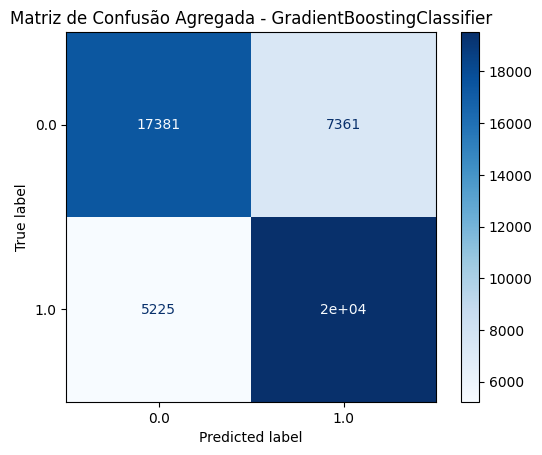

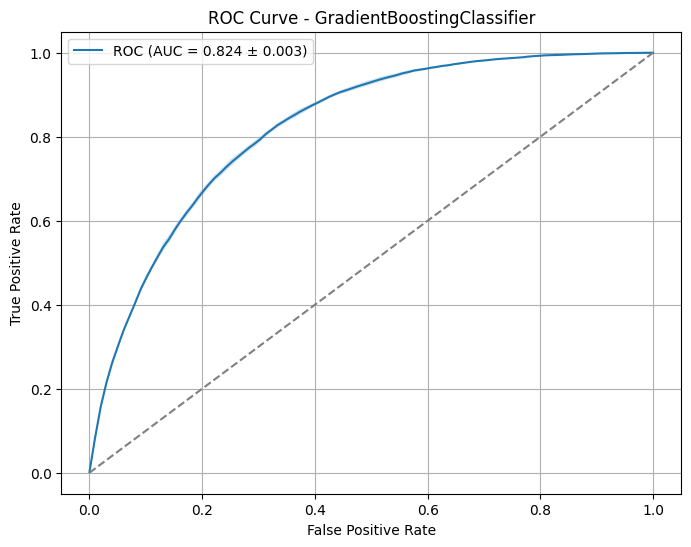

In [ ]:
# Parâmetros obtidos pelo Grid Search
# melhor_modelo = GradientBoostingClassifier(learning_rate=0.5, min_samples_leaf=2, min_samples_split=2)

# Salvando os resultados do modelo otimizado
resultados["Gradiente Boosting"] = model_cross_val(melhor_modelo, X_train_array, y_train_array, show_confusion_matrix=True)

### K - Nearest Neighbors

#### Testando o modelo com parâmetros default


=== KNeighborsClassifier ===
Acurácia média: 0.7112 ± 0.0067
F1 média:       0.7198 ± 0.0065
Precisão média: 0.6990 ± 0.0069
Recall médio:   0.7419 ± 0.0076
AUC média:      0.7694 ± 0.0058


<Figure size 600x500 with 0 Axes>

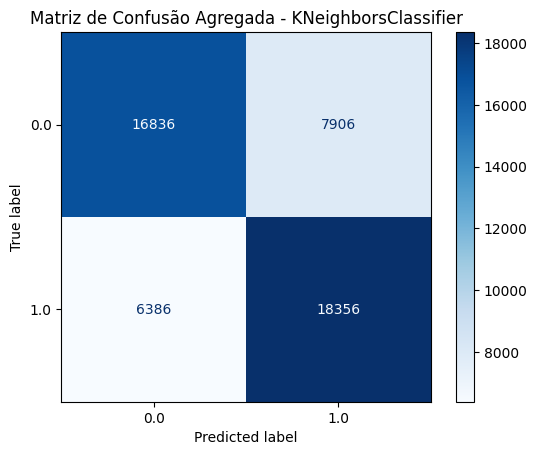

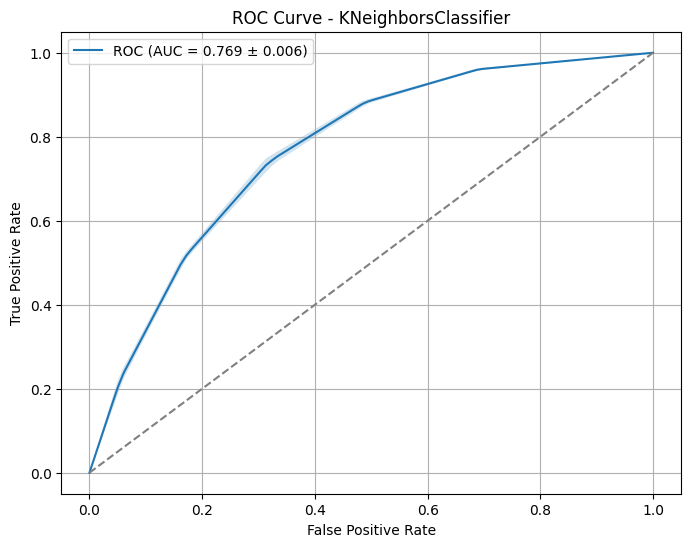

In [ ]:
# Definindo o modelo a ser testado
modelo = KNeighborsClassifier()

# Executo o modelo com parâmetros default
_ = model_cross_val(modelo, X_train_array, y_train_array, show_confusion_matrix=True)

#### Testando o modelo após usar GridSearchCV

In [ ]:
# Definindo parâmetros para o GridSearchCV
param_grid = {
    "n_neighbors": [3, 5, 7],
    "weights": ['uniform', 'distance'],
    "p": [1, 2],
    }

# Chamando a função do Grid Search
melhor_modelo = grid_search_with_cv(
    modelo,
    param_grid,
    X_train_array,
    y_train_array,
    cv=5
)

# Salvando o modelo com parâmetros otimizados
melhores_modelos['K-NN'] = melhor_modelo


=== Grid Search - KNeighborsClassifier ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores parâmetros: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Melhor score (recall): 0.7547



=== KNeighborsClassifier ===
Acurácia média: 0.7199 ± 0.0044
F1 média:       0.7300 ± 0.0038
Precisão média: 0.7047 ± 0.0057
Recall médio:   0.7573 ± 0.0059
AUC média:      0.7825 ± 0.0049


<Figure size 600x500 with 0 Axes>

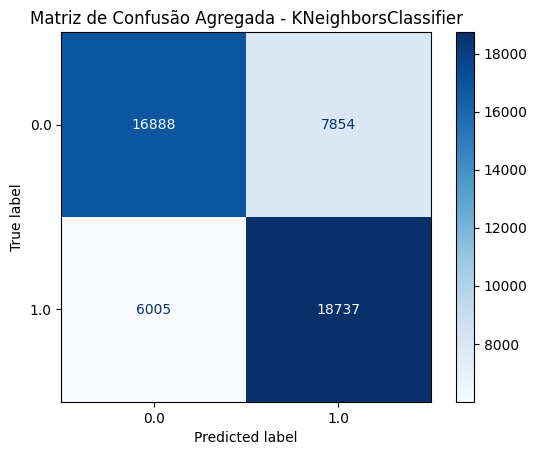

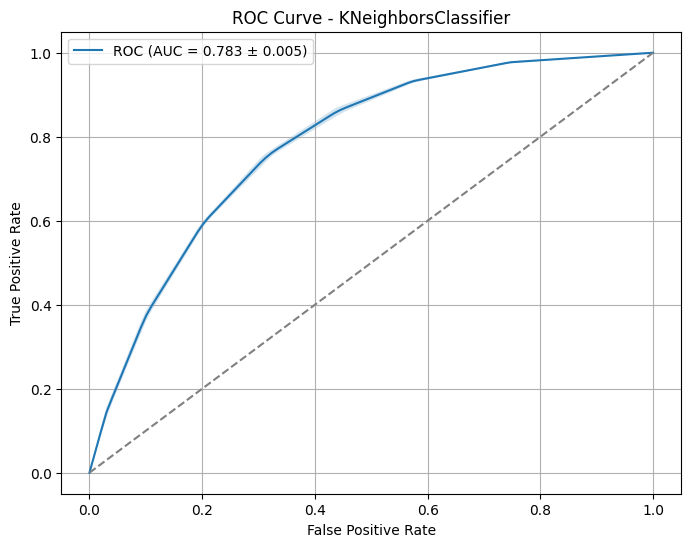

In [ ]:
# Parâmetros obtidos pelo Grid Search
# melhor_modelo = KNeighborsClassifier(n_neighbors=7, p=1, weights='uniform')

# Salvando os resultados do modelo otimizado
resultados["K-NN"] = model_cross_val(melhor_modelo, X_train_array, y_train_array, show_confusion_matrix=True)

### Naive Bayes

GaussianNB e BernouliNB são modelos não paramétricos, portanto dispensam o Grid Search

#### Gaussian


=== GaussianNB ===
Acurácia média: 0.7226 ± 0.0032
F1 média:       0.7206 ± 0.0041
Precisão média: 0.7259 ± 0.0033
Recall médio:   0.7155 ± 0.0077
AUC média:      0.7855 ± 0.0025


<Figure size 600x500 with 0 Axes>

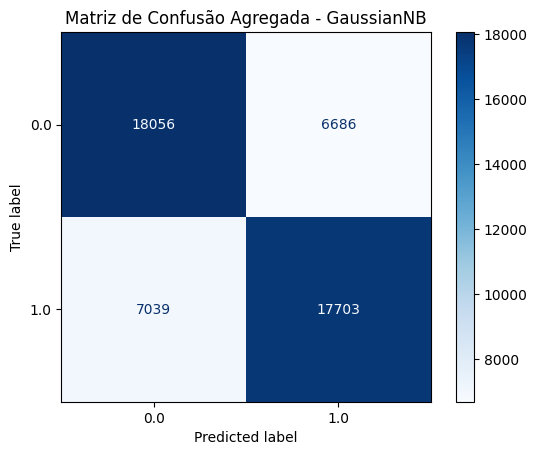

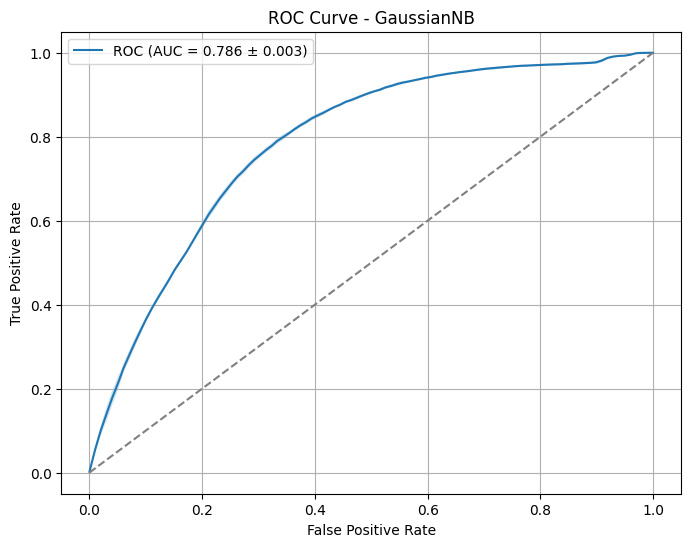

In [ ]:
# Definindo o modelo a ser testado
modelo = GaussianNB()

# Salvando o modelo
melhores_modelos['GaussianNB'] = modelo

# Salvando os resultados do modelo otimizado
resultados['GaussianNB'] = model_cross_val(modelo, X_train_array, y_train_array, show_confusion_matrix=True)

#### Bernoulli


=== BernoulliNB ===
Acurácia média: 0.7317 ± 0.0041
F1 média:       0.7310 ± 0.0033
Precisão média: 0.7330 ± 0.0060
Recall médio:   0.7291 ± 0.0036
AUC média:      0.8054 ± 0.0037


<Figure size 600x500 with 0 Axes>

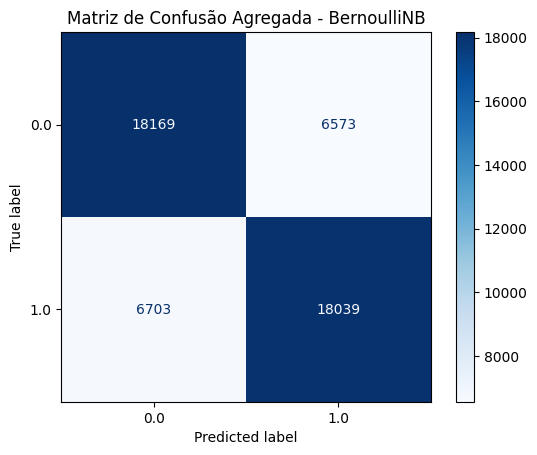

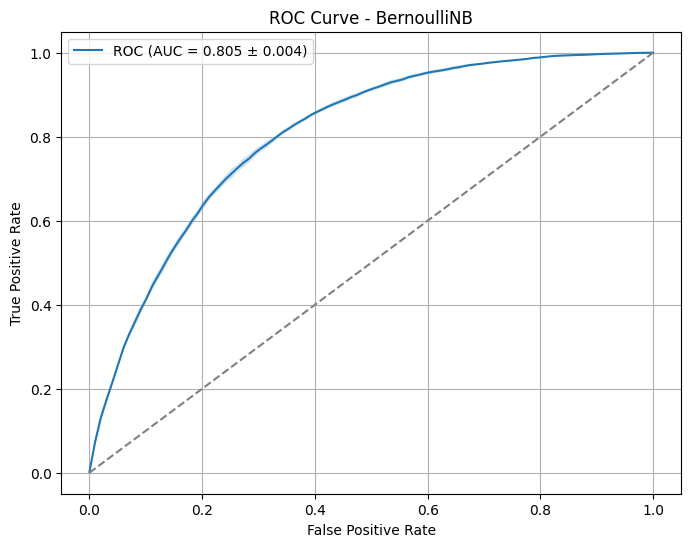

In [ ]:
# Definindo o modelo a ser testado
modelo = BernoulliNB()

# Salvando o modelo
melhores_modelos['BernouliNB'] = modelo

# Salvando os resultados do modelo otimizado
resultados['BernouliNB'] = model_cross_val(modelo, X_train_array, y_train_array, show_confusion_matrix=True)

## Salvando os resultados obtidos de cada modelo

In [ ]:
df_resultados = pd.DataFrame(resultados).T
df_resultados = df_resultados.round(4)
print(df_resultados.sort_values('recall', ascending=False))

                        accuracy      f1  precision  recall     auc
SVM                       0.7475  0.7651     0.7154  0.8222  0.8235
Gradiente Boosting        0.7457  0.7562     0.7262  0.7888  0.8236
RandomForestClassifier    0.7434  0.7537     0.7246  0.7852  0.8209
LogisticRegression        0.7468  0.7528     0.7356  0.7709  0.8222
K-NN                      0.7199  0.7300     0.7047  0.7573  0.7825
BernouliNB                0.7317  0.7310     0.7330  0.7291  0.8054
GaussianNB                0.7226  0.7206     0.7259  0.7155  0.7855
DecisionTreeClassifier    0.6135  0.5622     0.4963  0.6675  0.6135
Perceptron                0.5984  0.4426     0.5468  0.4169  0.6614


## Avaliação Final

In [ ]:
# Para avaliação final no conjunto de teste
def avaliar_modelo_final(model, X_train, y_train, X_test, y_test):
    # Normalizar usando TODO o conjunto de treino
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Treinar modelo final
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    print(f"\n=== Avaliação Final - {model.__class__.__name__} ===")
    print(f"Acurácia no teste: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 no teste:       {f1_score(y_test, y_pred):.4f}")
    print(f"Precisão no teste: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall no teste:   {recall_score(y_test, y_pred):.4f}")

    # Matriz de confusão no conjunto de teste final
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, cmap='Blues')
    plt.title(f'Matriz de Confusão - Teste Final - {model.__class__.__name__}')
    plt.show()


Melhor modelo: SVM
Parâmetros: {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

=== Avaliação Final - SVC ===
Acurácia no teste: 0.7502
F1 no teste:       0.7677
Precisão no teste: 0.7174
Recall no teste:   0.8256


<Figure size 800x600 with 0 Axes>

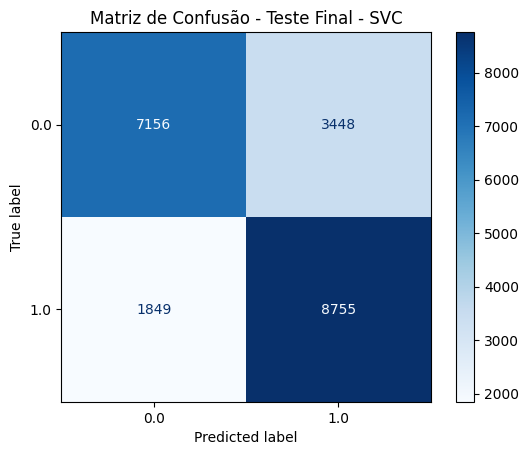

In [ ]:
# Escolher melhor modelo baseado no Recall-score
melhor_modelo_nome = df_resultados['recall'].idxmax()
melhor_modelo = melhores_modelos[melhor_modelo_nome]

print(f"\nMelhor modelo: {melhor_modelo_nome}")
print(f"Parâmetros: {melhor_modelo.get_params()}")

# melhor_modelo = SVC(C = 1, break_ties = False, cache_size = 200, 
#                     class_weight = None, coef0 = 0.0, 
#                     decision_function_shape = 'ovr', degree = 3, 
#                     gamma = 0.01, kernel = 'rbf', max_iter = -1, 
#                     probability = True, random_state = None, 
#                     shrinking = True, tol = 0.001, verbose = False)

print(f"\nMelhor modelo: SVM")
print(f"Parâmetros: {melhor_modelo.get_params()}")

# Avaliação final
resultado_final = avaliar_modelo_final(
    melhor_modelo,
    X_train_array,
    y_train_array,
    X_test_array,
    y_test_array
)